In [2]:
import tensorflow as tf
from dataset import load_dataset_from_tfrecord
import os
import wandb
from loss_functions import ssim_loss, combined_loss, custom_ssim_loss, custom_multi_ssim_loss, get_custom_loss
from tensorflow.keras import layers, models
from image_utils import display_images_and_histograms
from evaluation import fmi_score, ssim_score
import numpy as np
import time

# Check GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Set TensorFlow to only allocate memory as needed on GPU, not all upfront
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Training on GPU:", gpus)
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print("Failed to set memory growth on GPU:", e)
else:
    print("No GPU found, training will be performed on CPU.")

# Set a fixed seed for NumPy and TensorFlow random number generators
np.random.seed(42)
tf.random.set_seed(42)

2.10.0
Training on GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Load the dataset
modalities = ['t2w', 't1w']
loaded_dataset = load_dataset_from_tfrecord(os.path.join('datasets', '_'.join(modalities) + '_dataset.tfrecord'), modalities)

DATASET_SIZE = sum(1 for _ in loaded_dataset)
TRAIN_SIZE = int(0.8 * DATASET_SIZE)
VAL_SIZE = int(0.1 * DATASET_SIZE)
TEST_SIZE = DATASET_SIZE - TRAIN_SIZE - VAL_SIZE

# Shuffle the dataset with a fixed buffer size and seed
full_dataset = loaded_dataset.shuffle(buffer_size=DATASET_SIZE, reshuffle_each_iteration=False)

# Split the dataset
train_dataset = full_dataset.take(TRAIN_SIZE)
test_val_dataset = full_dataset.skip(TRAIN_SIZE)
val_dataset = test_val_dataset.take(VAL_SIZE)
test_dataset = test_val_dataset.skip(VAL_SIZE)

BATCH_SIZE = 16
train_dataset = train_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [4]:
# Ajouter des branches pour d'autres contrastes T1w,T2w,T2*w,MT-on,GRE-T1wandDWI

def multi_scale_features(input_tensor, filters, name_prefix):
    # Path 1: Original scale
    path1 = layers.Conv2D(filters, 3, padding='same', name=name_prefix+'_conv1')(input_tensor)
    path1 = layers.BatchNormalization(name=name_prefix+'_bn1')(path1)
    path1 = layers.ReLU(name=name_prefix+'_relu1')(path1)

    # Path 2: Down-sampled scale
    path2 = layers.Conv2D(filters, 3, strides=2, padding='same', name=name_prefix+'_conv2')(input_tensor)
    path2 = layers.BatchNormalization(name=name_prefix+'_bn2')(path2)
    path2 = layers.ReLU(name=name_prefix+'_relu2')(path2)
    # Upsample to original size
    path2 = layers.UpSampling2D(size=(2, 2), name=name_prefix+'_upsample2')(path2)

    # Combine multi-scale features
    combined_features = layers.Concatenate(axis=-1)([path1, path2])
    return combined_features

# def build_model(input_shapes):
#     inputs = [layers.Input(shape=shape, name=f'image{i+1}') for i, shape in enumerate(input_shapes)]
#     multi_scale_branches = []

#     for i, input_tensor in enumerate(inputs):
#         # Extract multi-scale features
#         ms_features = multi_scale_features(input_tensor, 32, name_prefix=f'ms_branch{i+1}')
#         # Pass the combined features through a residual block
#         res_block = residual_block(ms_features, 64, name=f'res_block_ms_branch{i+1}')
#         multi_scale_branches.append(res_block)
# 
    # if len(multi_scale_branches) > 1:
    #     concatenated_features = layers.Concatenate(axis=-1)(multi_scale_branches)
    # else:
    #     concatenated_features = multi_scale_branches[0]
#  # Final layers after fusion
#     res_block_concat = residual_block(concatenated_features, 128, name='res_block_concat')
    # conv2 = layers.Conv2D(32, 3, strides=1, padding='same', name='conv2')(res_block_concat)
    # conv3 = layers.Conv2D(1, 3, strides=1, padding='same', name='conv3')(conv2)

    # sigmoid_output = layers.Activation('sigmoid')(conv3)
    # weighted_avg_inputs = layers.Average()(inputs + [sigmoid_output])


#     model = models.Model(inputs=inputs, outputs=weighted_avg_inputs)
#     return model


def residual_block(x, filters, kernel_size=3, stride=1, conv_shortcut=False, name=None):
    shortcut = x
    if conv_shortcut:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same', name=name+'_shortcut')(shortcut)
        shortcut = layers.BatchNormalization(name=name+'_shortcut_bn')(shortcut)

    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same', name=name+'_conv1')(x)
    x = layers.BatchNormalization(name=name+'_bn1')(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, kernel_size, padding='same', name=name+'_conv2')(x)
    x = layers.BatchNormalization(name=name+'_bn2')(x)
    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)

    return x

def build_model(input_shapes):
    inputs = [layers.Input(shape=shape, name=f'image{i+1}') for i, shape in enumerate(input_shapes)]
    branches = []

    for i, input_tensor in enumerate(inputs):
        conv1 = layers.Conv2D(32, 3, strides=1, padding='same', name=f'conv1_branch{i+1}')(input_tensor)
        res_block = residual_block(conv1, 32, name=f'res_block_branch{i+1}')
        branches.append(res_block)

    if len(branches) > 1:
        concatenated_features = layers.Concatenate(axis=-1)(branches)
    else:
        concatenated_features = branches[0]

    res_block_concat = residual_block(concatenated_features, 64, name='res_block_concat')

    conv2 = layers.Conv2D(32, 3, strides=1, padding='same', name='conv2')(res_block_concat)
    conv3 = layers.Conv2D(1, 3, strides=1, padding='same', name='conv3')(conv2)

    sigmoid_output = layers.Activation('sigmoid')(conv3)
    weighted_avg_inputs = layers.Average()(inputs + [sigmoid_output])

    model = models.Model(inputs=inputs, outputs=weighted_avg_inputs)
    return model

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: biancapopa. Use `wandb login --relogin` to force relogin


Training on GPU, with alpha=1, beta=1, gamma=1
Epoch 1/100, Train Loss: 0.1694, Validation Loss: 0.1912
Epoch 2/100, Train Loss: 0.1523, Validation Loss: 0.1656
Epoch 3/100, Train Loss: 0.1518, Validation Loss: 0.1515
Epoch 4/100, Train Loss: 0.1516, Validation Loss: 0.1524
Epoch 5/100, Train Loss: 0.1514, Validation Loss: 0.1518


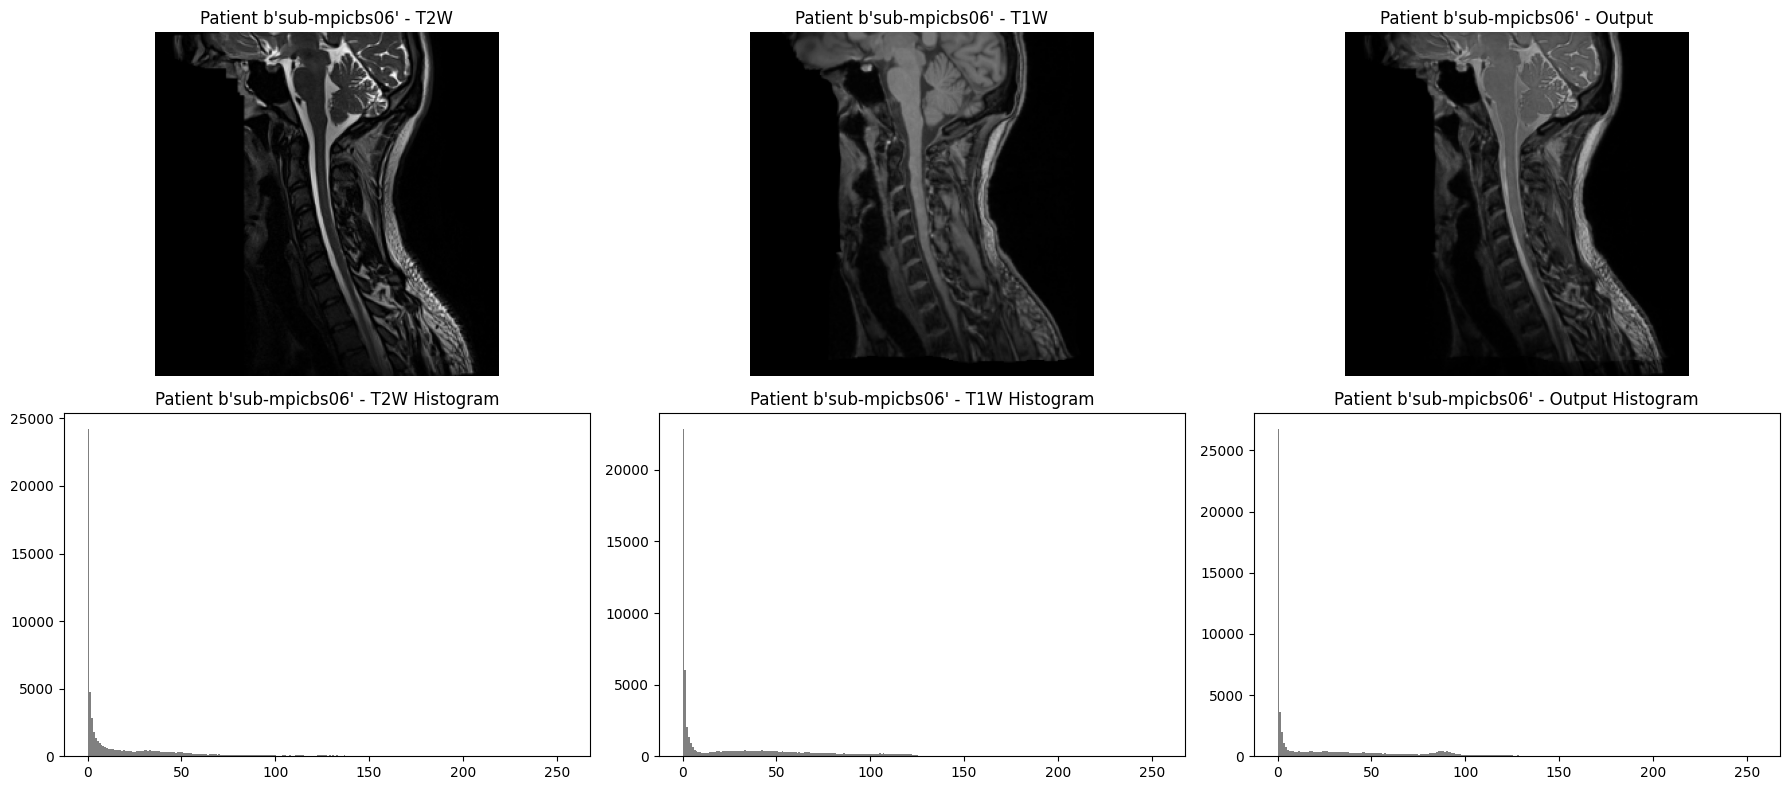

Epoch 6/100, Train Loss: 0.1513, Validation Loss: 0.1514
Epoch 7/100, Train Loss: 0.1513, Validation Loss: 0.1517
Epoch 8/100, Train Loss: 0.1513, Validation Loss: 0.1518
Epoch 9/100, Train Loss: 0.1512, Validation Loss: 0.1517
Epoch 10/100, Train Loss: 0.1512, Validation Loss: 0.1525


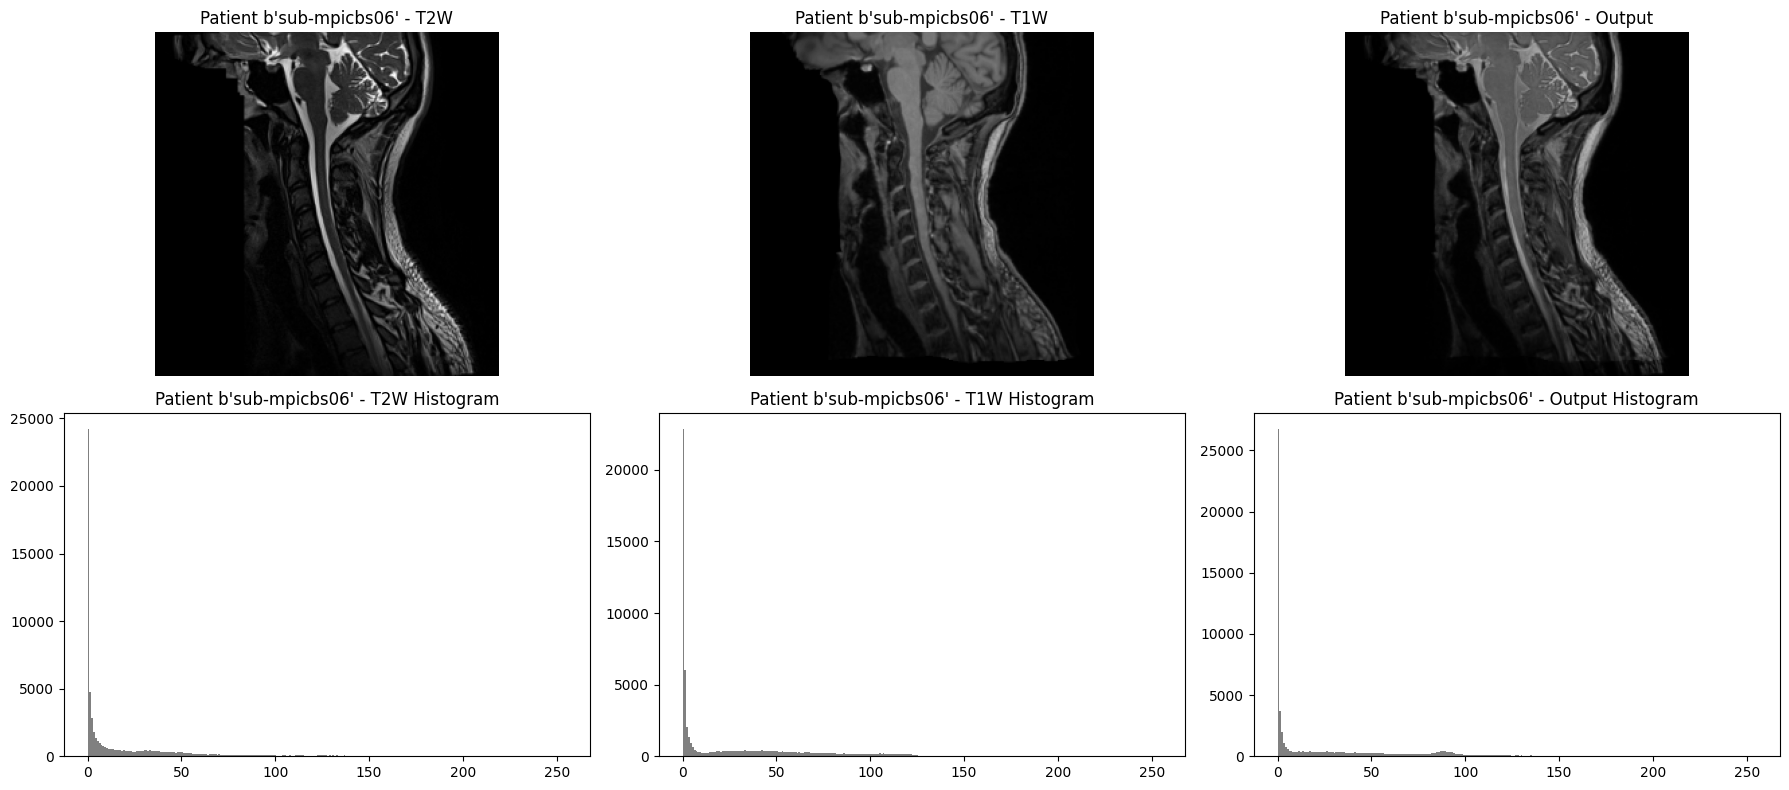

Epoch 11/100, Train Loss: 0.1512, Validation Loss: 0.1515
Early stopping...
Training finished in 581.08 seconds
Validation SSIM: 0.8495, Validation FMI: 0.8541
New best model saved with alpha=1, beta=1, gamma=1
Training on GPU, with alpha=1, beta=1, gamma=2
Epoch 1/100, Train Loss: 0.2955, Validation Loss: 0.2910
Epoch 2/100, Train Loss: 0.2731, Validation Loss: 0.2791
Epoch 3/100, Train Loss: 0.2728, Validation Loss: 0.2742
Epoch 4/100, Train Loss: 0.2727, Validation Loss: 0.2728
Epoch 5/100, Train Loss: 0.2726, Validation Loss: 0.2723


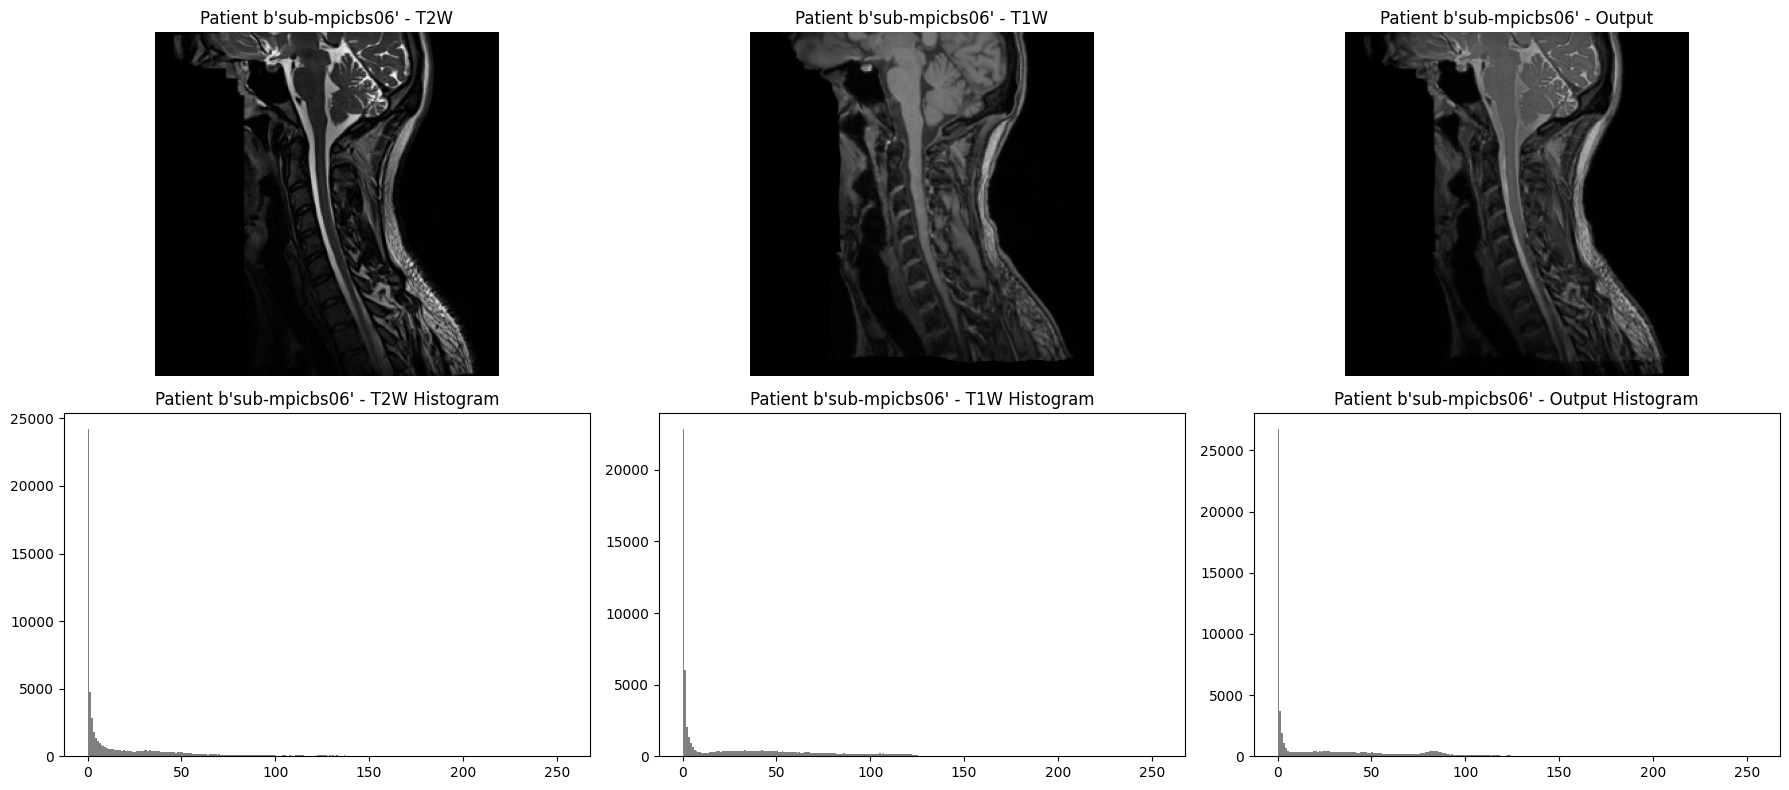

Epoch 6/100, Train Loss: 0.2725, Validation Loss: 0.2722
Epoch 7/100, Train Loss: 0.2725, Validation Loss: 0.2722
Epoch 8/100, Train Loss: 0.2725, Validation Loss: 0.2723
Epoch 9/100, Train Loss: 0.2725, Validation Loss: 0.2722
Epoch 10/100, Train Loss: 0.2725, Validation Loss: 0.2721


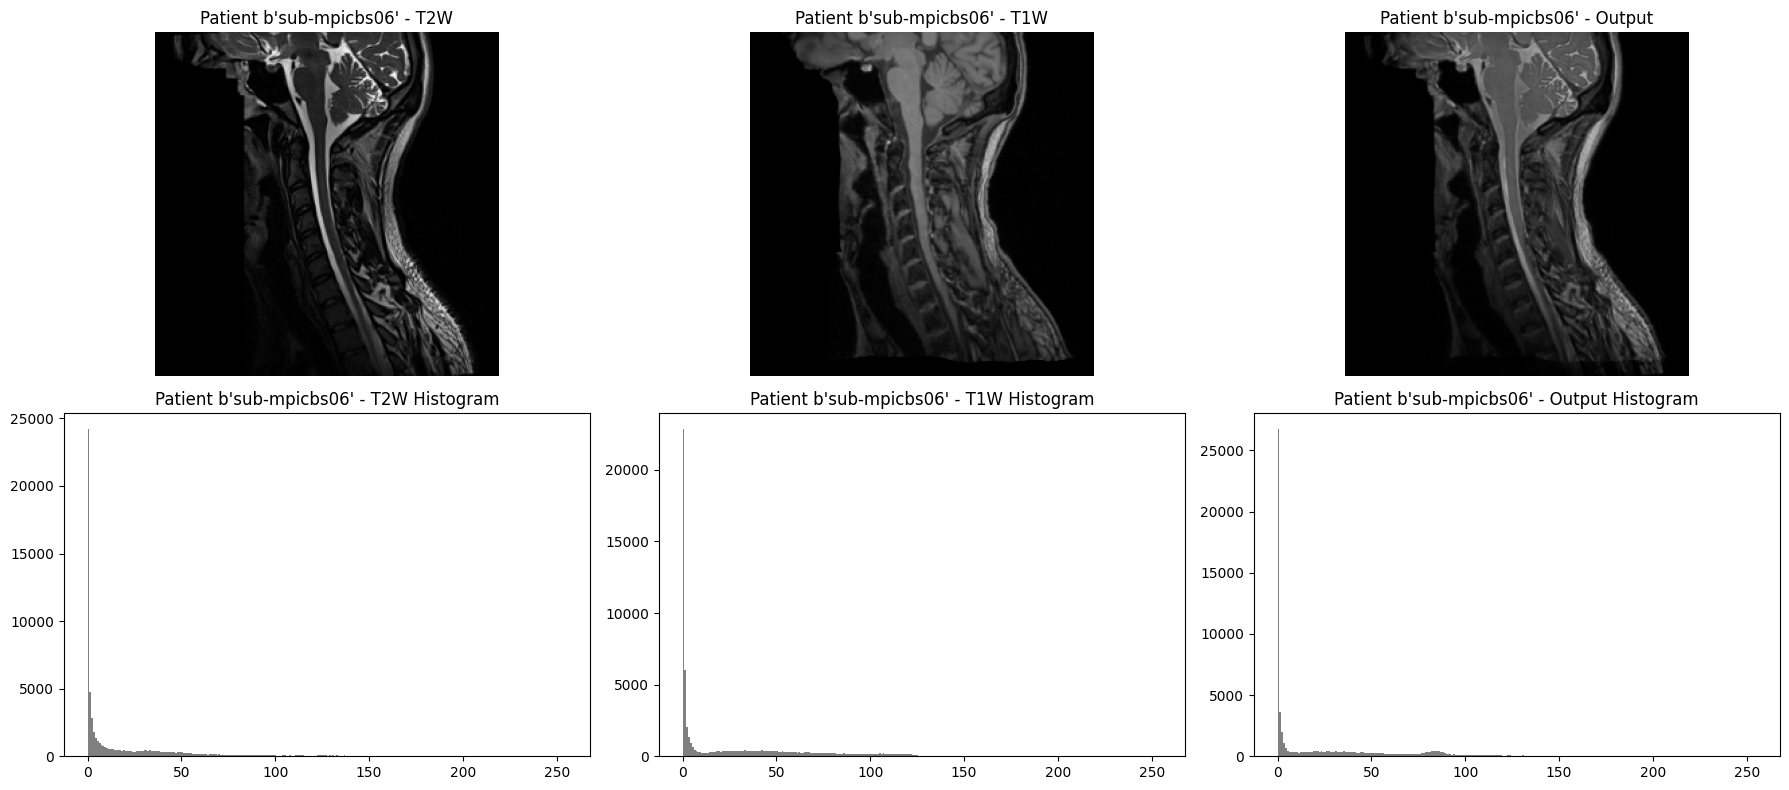

Epoch 11/100, Train Loss: 0.2724, Validation Loss: 0.2722
Epoch 12/100, Train Loss: 0.2724, Validation Loss: 0.2721
Epoch 13/100, Train Loss: 0.2724, Validation Loss: 0.2721
Epoch 14/100, Train Loss: 0.2724, Validation Loss: 0.2720
Epoch 15/100, Train Loss: 0.2724, Validation Loss: 0.2720


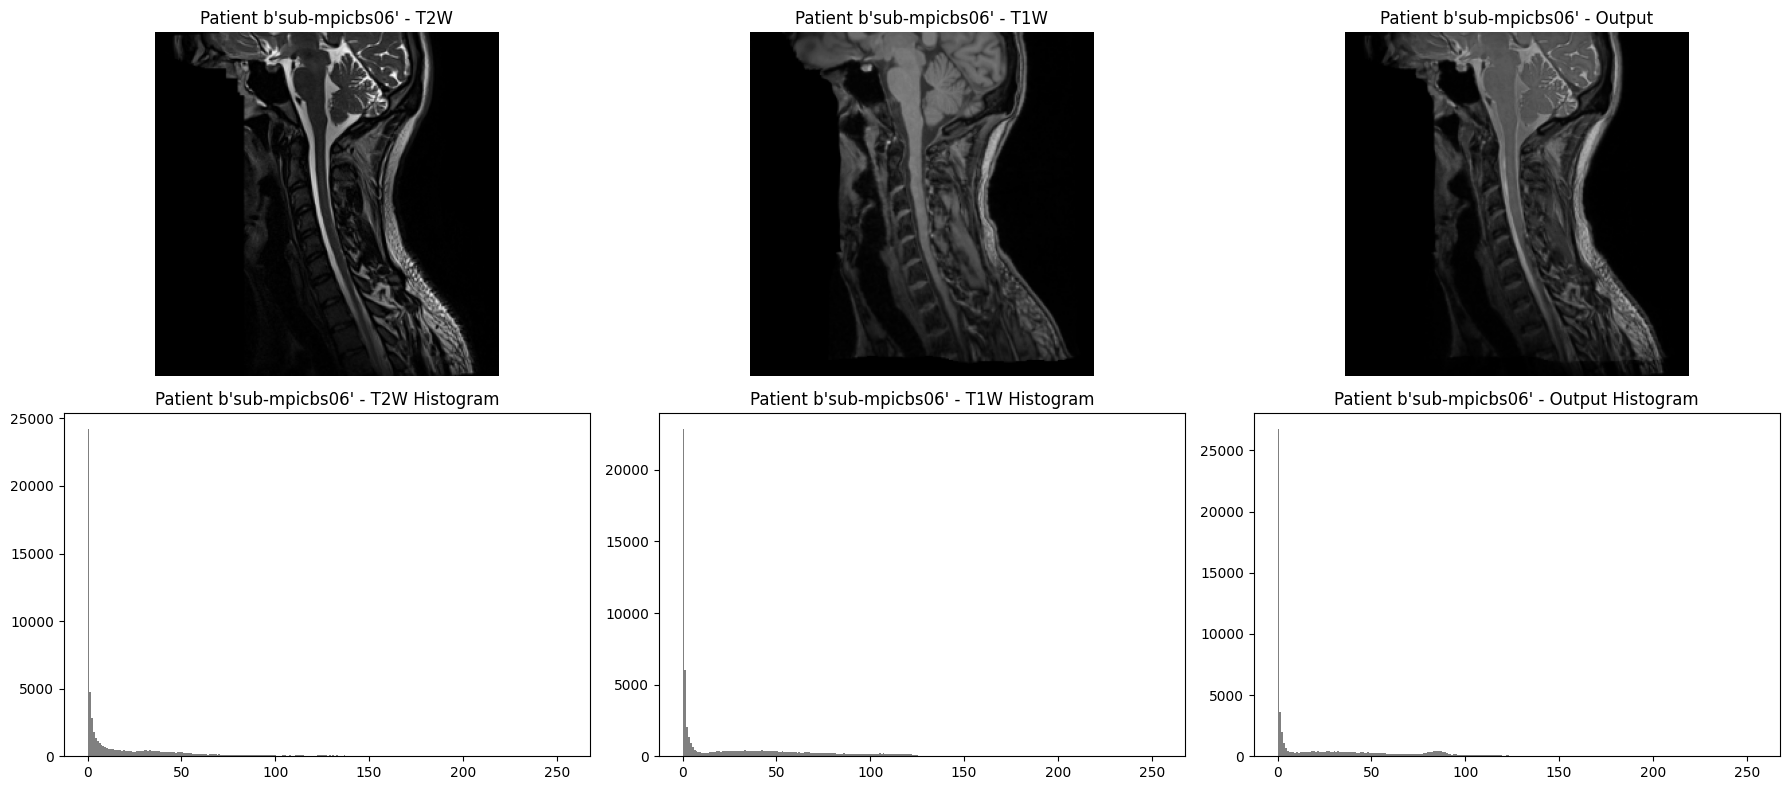

Epoch 16/100, Train Loss: 0.2724, Validation Loss: 0.2720
Epoch 17/100, Train Loss: 0.2723, Validation Loss: 0.2720
Epoch 18/100, Train Loss: 0.2723, Validation Loss: 0.2720
Epoch 19/100, Train Loss: 0.2723, Validation Loss: 0.2720
Epoch 20/100, Train Loss: 0.2723, Validation Loss: 0.2720


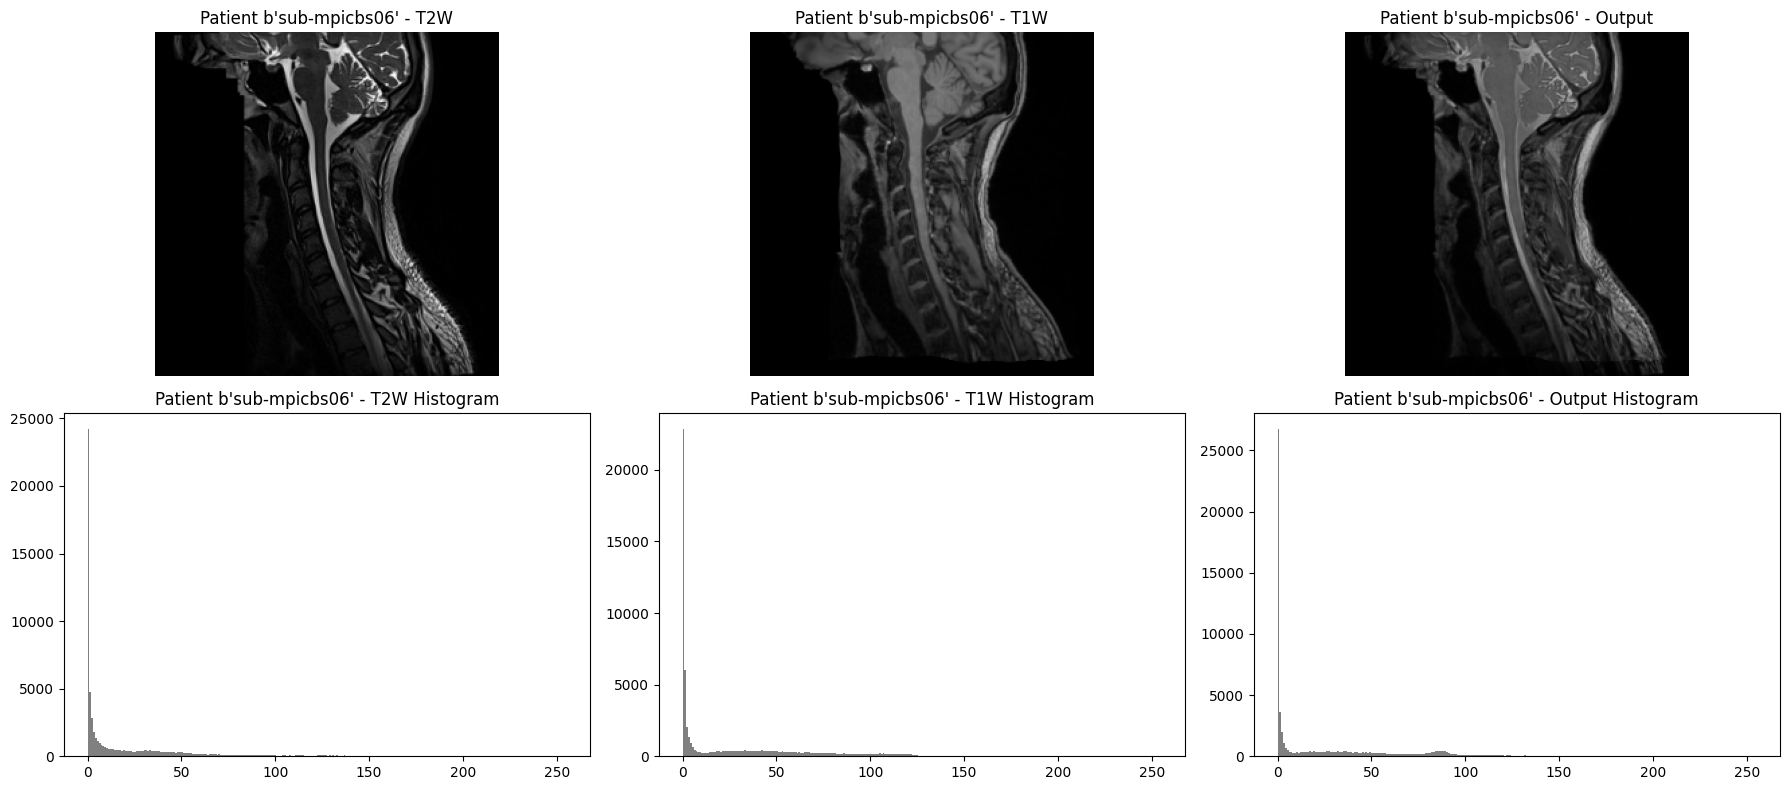

Epoch 21/100, Train Loss: 0.2723, Validation Loss: 0.2720
Epoch 22/100, Train Loss: 0.2723, Validation Loss: 0.2720
Epoch 23/100, Train Loss: 0.2723, Validation Loss: 0.2720
Epoch 24/100, Train Loss: 0.2723, Validation Loss: 0.2720
Early stopping...
Training finished in 1280.27 seconds
Validation SSIM: 0.7699, Validation FMI: 0.8552
Training on GPU, with alpha=1, beta=1, gamma=3
Epoch 1/100, Train Loss: 0.3993, Validation Loss: 0.3939
Epoch 2/100, Train Loss: 0.3770, Validation Loss: 0.3770
Epoch 3/100, Train Loss: 0.3766, Validation Loss: 0.3759
Epoch 4/100, Train Loss: 0.3765, Validation Loss: 0.3759
Epoch 5/100, Train Loss: 0.3764, Validation Loss: 0.3758


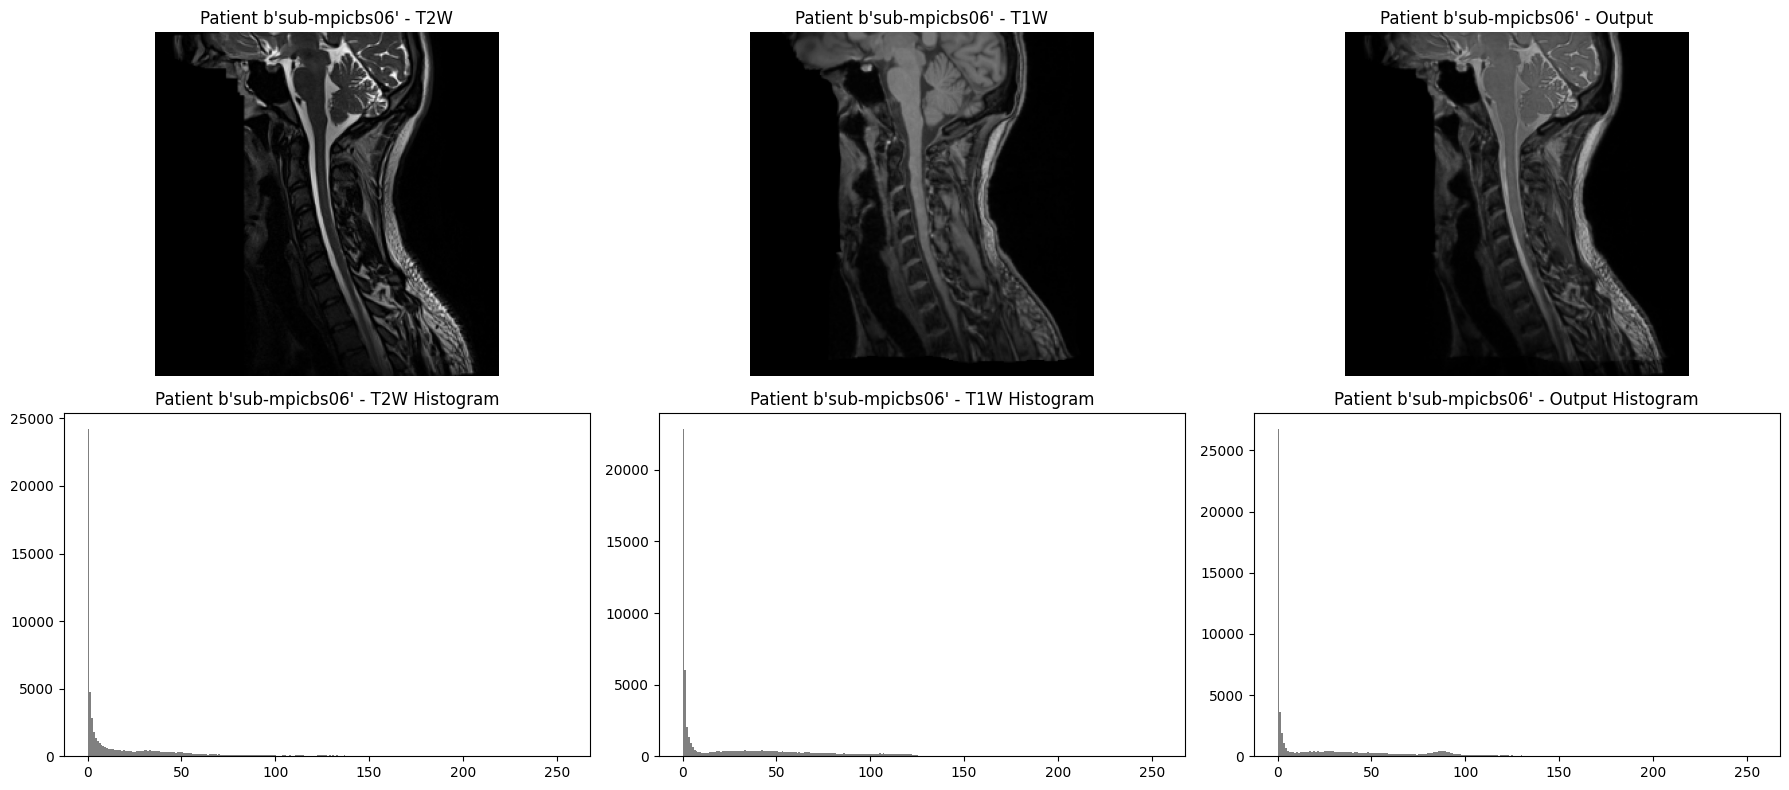

Epoch 6/100, Train Loss: 0.3763, Validation Loss: 0.3758
Epoch 7/100, Train Loss: 0.3762, Validation Loss: 0.3758
Epoch 8/100, Train Loss: 0.3762, Validation Loss: 0.3758
Epoch 9/100, Train Loss: 0.3762, Validation Loss: 0.3758
Epoch 10/100, Train Loss: 0.3761, Validation Loss: 0.3758


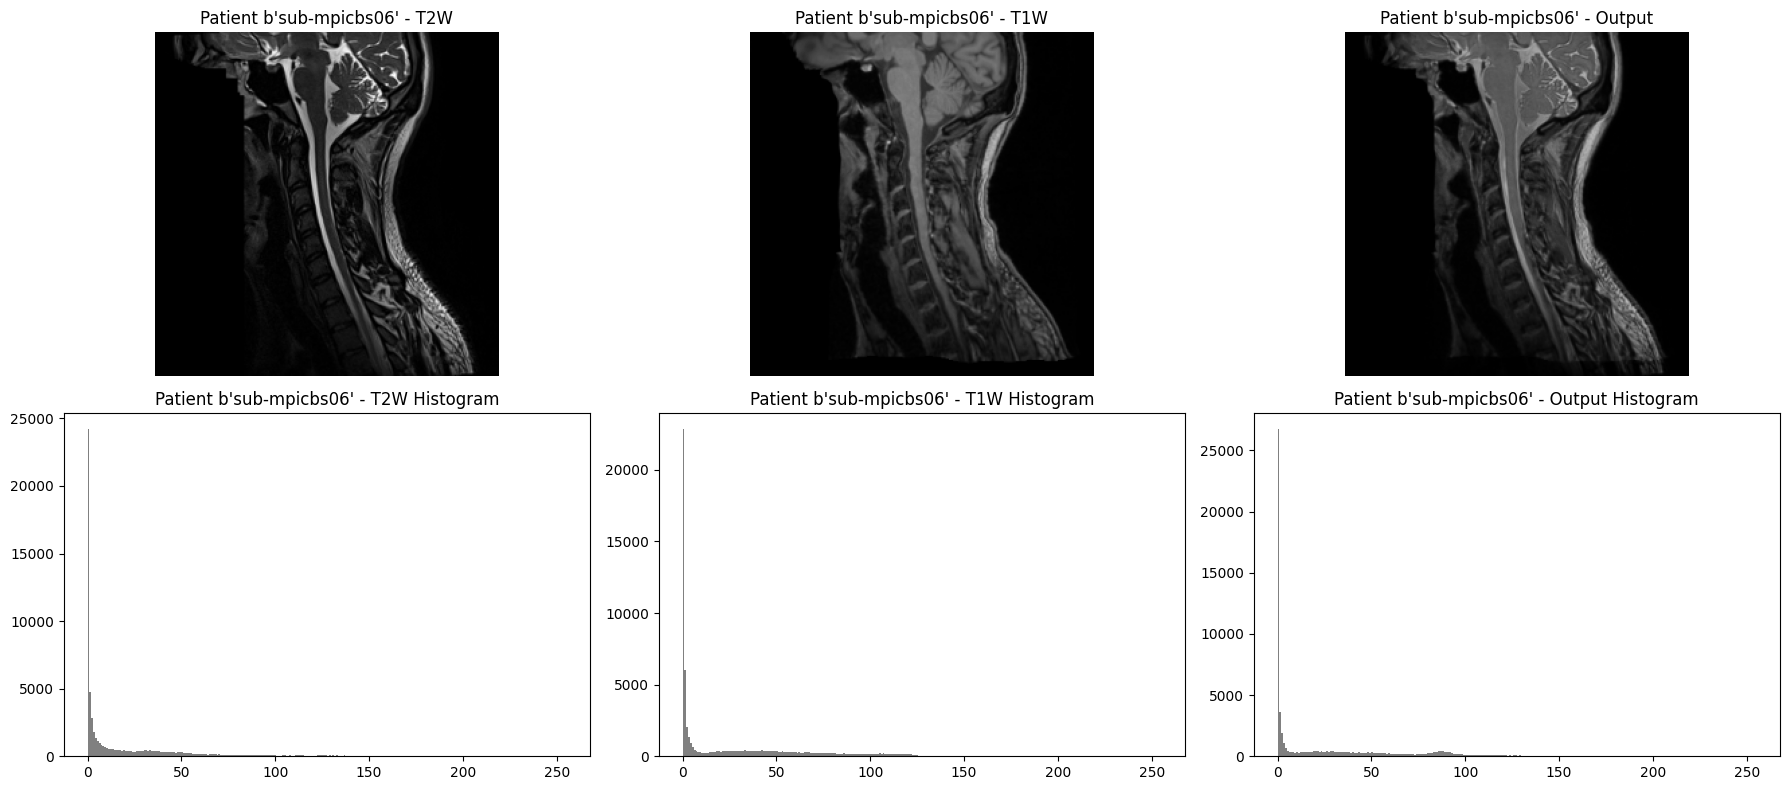

Epoch 11/100, Train Loss: 0.3761, Validation Loss: 0.3757
Epoch 12/100, Train Loss: 0.3761, Validation Loss: 0.3757
Epoch 13/100, Train Loss: 0.3760, Validation Loss: 0.3756
Epoch 14/100, Train Loss: 0.3760, Validation Loss: 0.3756
Epoch 15/100, Train Loss: 0.3760, Validation Loss: 0.3755


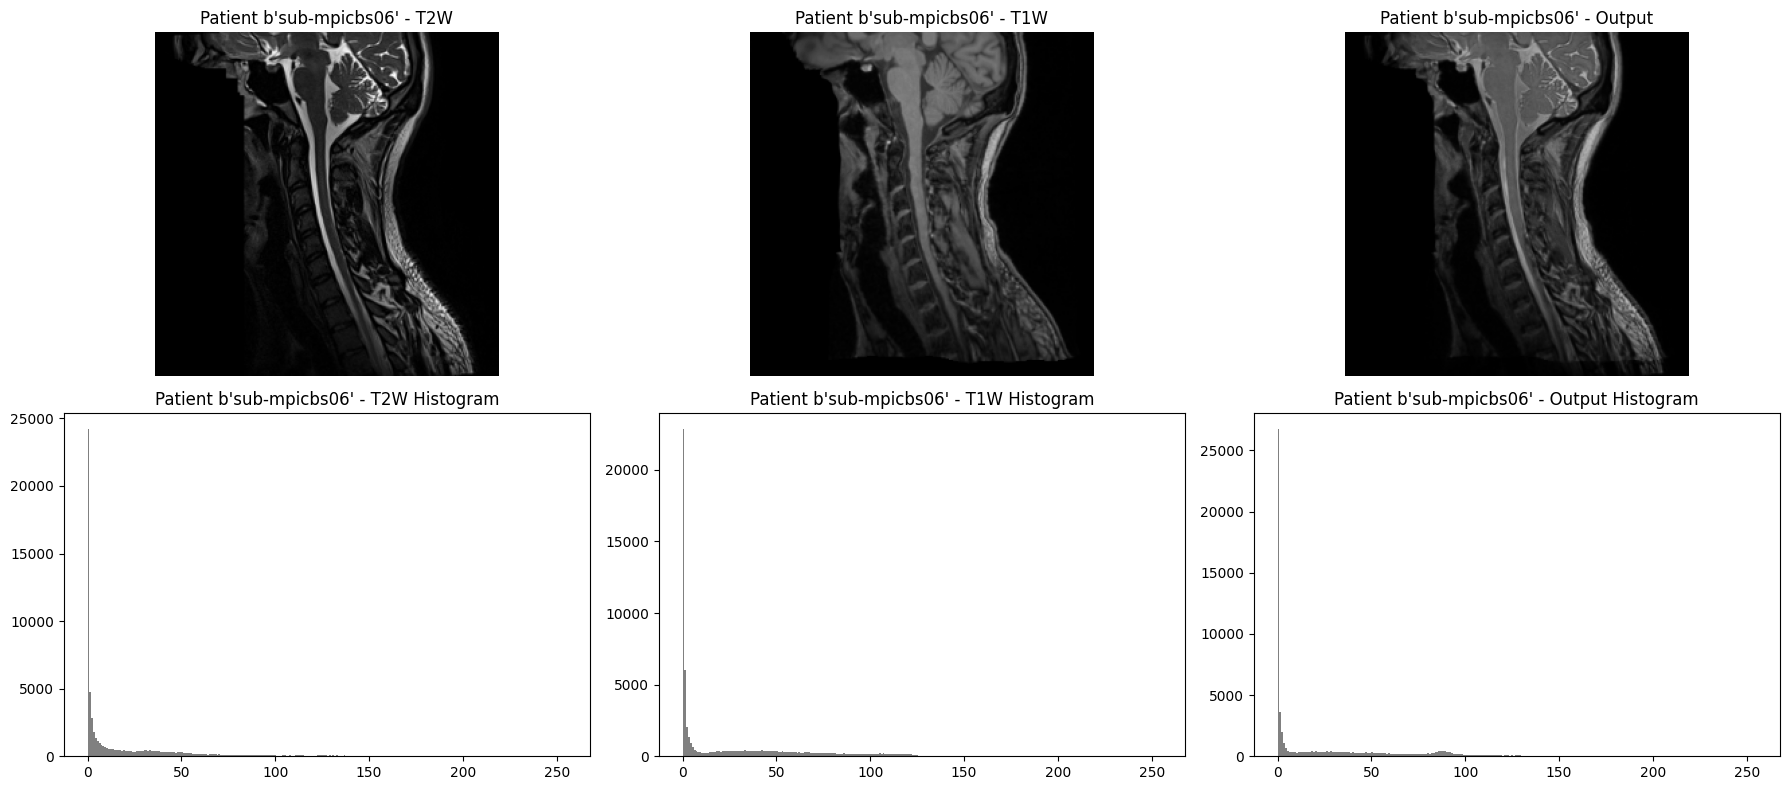

Epoch 16/100, Train Loss: 0.3760, Validation Loss: 0.3755
Epoch 17/100, Train Loss: 0.3760, Validation Loss: 0.3755
Epoch 18/100, Train Loss: 0.3759, Validation Loss: 0.3755
Epoch 19/100, Train Loss: 0.3759, Validation Loss: 0.3755
Epoch 20/100, Train Loss: 0.3759, Validation Loss: 0.3755


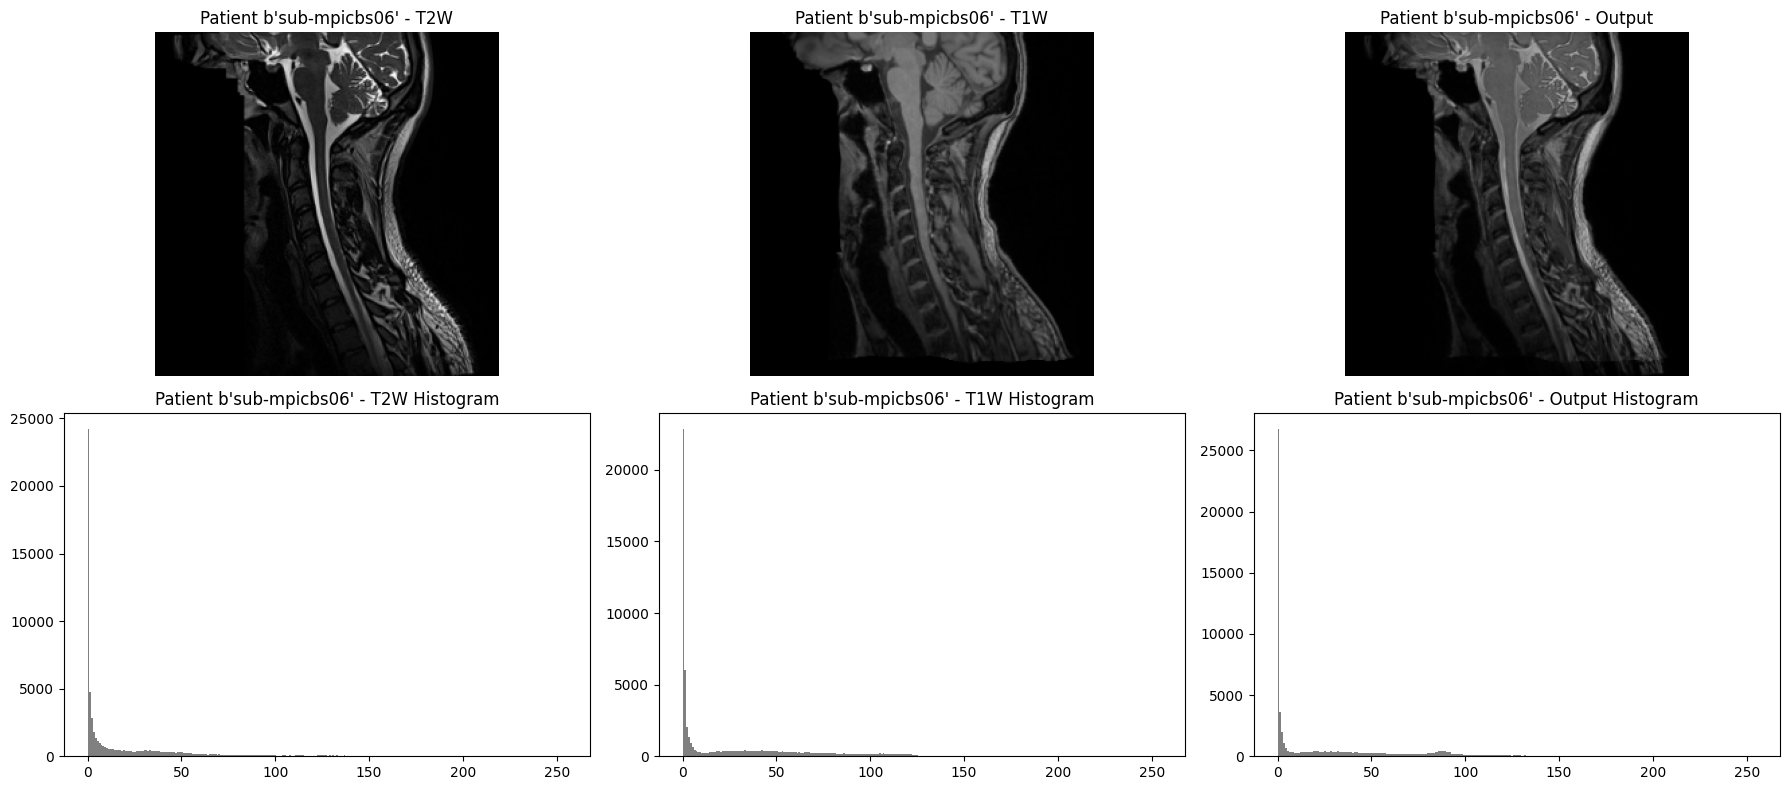

Epoch 21/100, Train Loss: 0.3759, Validation Loss: 0.3755
Epoch 22/100, Train Loss: 0.3759, Validation Loss: 0.3756
Epoch 23/100, Train Loss: 0.3759, Validation Loss: 0.3756
Epoch 24/100, Train Loss: 0.3759, Validation Loss: 0.3756
Epoch 25/100, Train Loss: 0.3759, Validation Loss: 0.3756
Early stopping...
Training finished in 1347.52 seconds
Validation SSIM: 0.7125, Validation FMI: 0.8552
Training on GPU, with alpha=1, beta=1, gamma=4
Epoch 1/100, Train Loss: 0.5260, Validation Loss: 0.5328
Epoch 2/100, Train Loss: 0.4668, Validation Loss: 0.4663
Epoch 3/100, Train Loss: 0.4655, Validation Loss: 0.4647
Epoch 4/100, Train Loss: 0.4650, Validation Loss: 0.4646
Epoch 5/100, Train Loss: 0.4648, Validation Loss: 0.4640


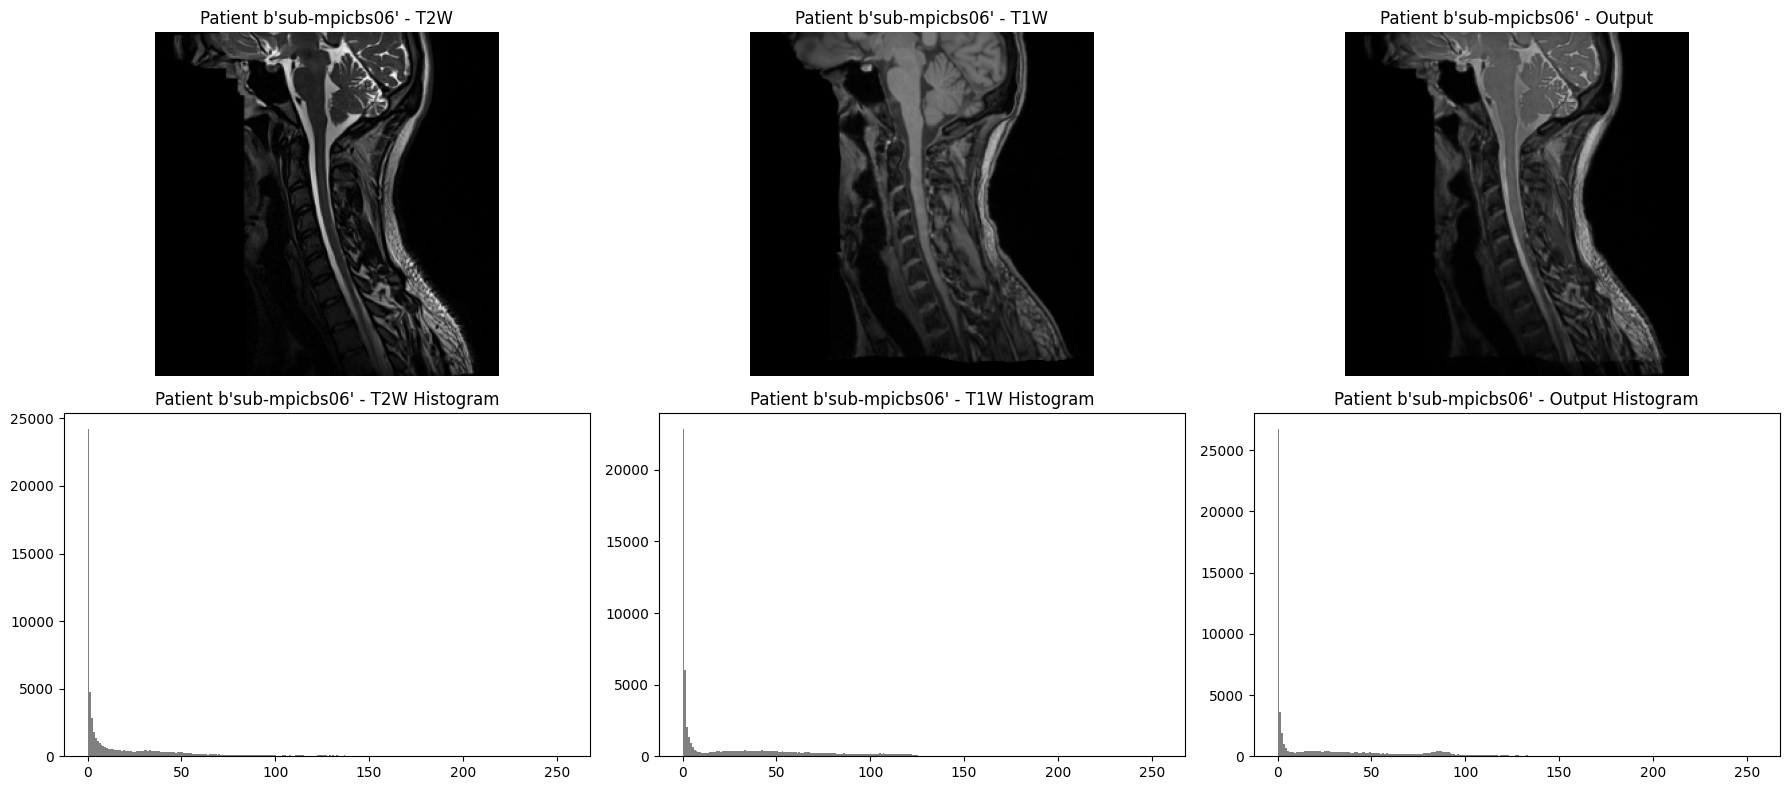

Epoch 6/100, Train Loss: 0.4647, Validation Loss: 0.4640
Epoch 7/100, Train Loss: 0.4647, Validation Loss: 0.4640
Epoch 8/100, Train Loss: 0.4646, Validation Loss: 0.4641
Epoch 9/100, Train Loss: 0.4646, Validation Loss: 0.4641
Epoch 10/100, Train Loss: 0.4645, Validation Loss: 0.4641


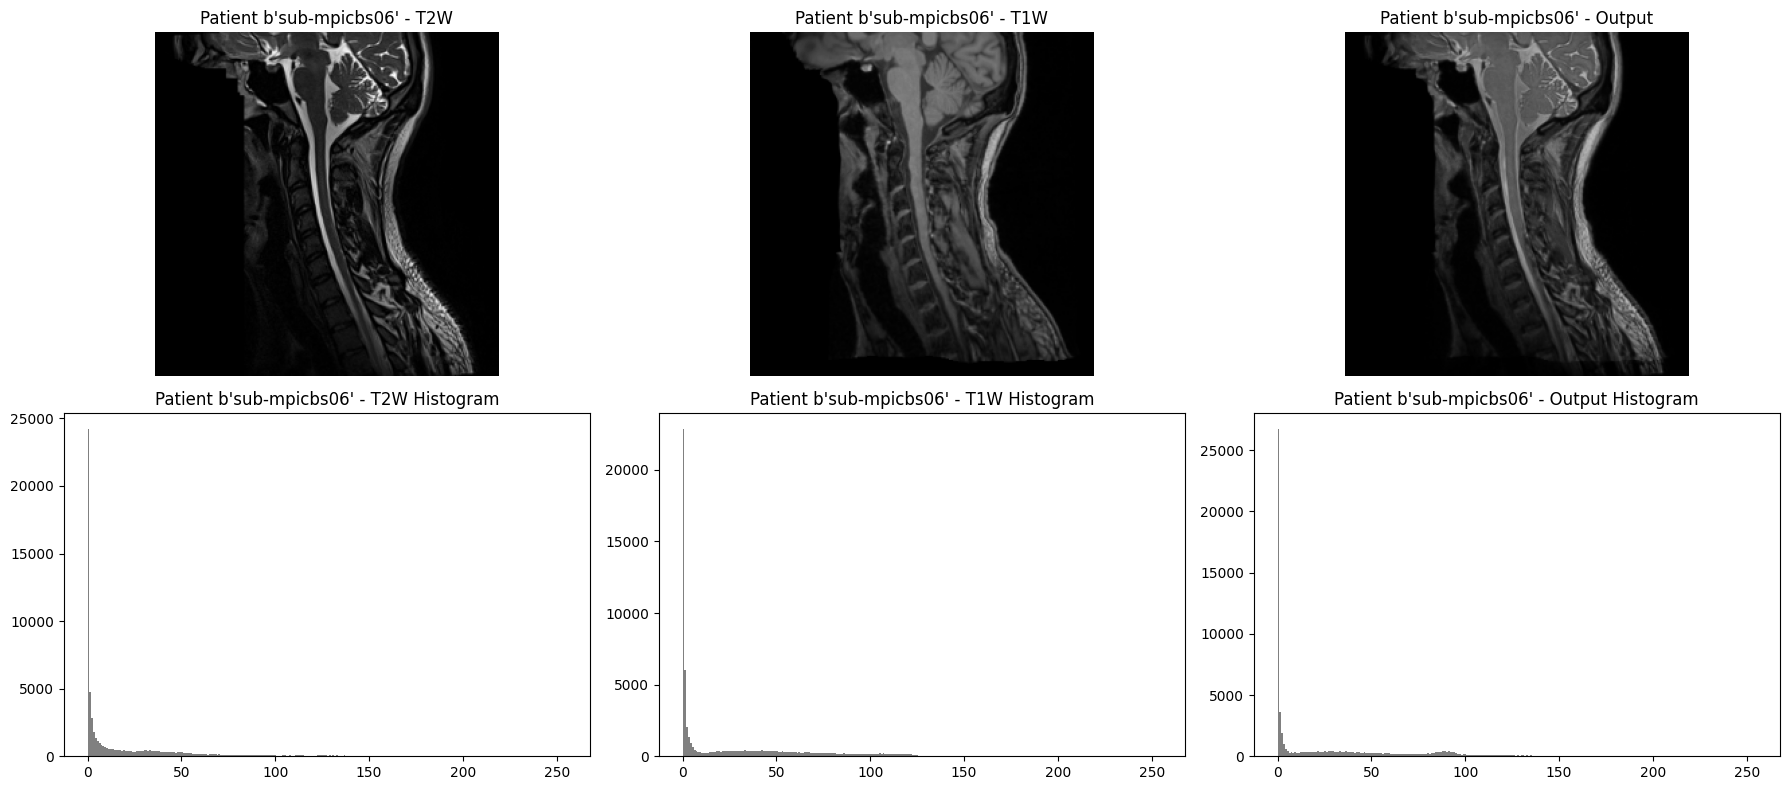

Epoch 11/100, Train Loss: 0.4645, Validation Loss: 0.4641
Early stopping...
Training finished in 597.98 seconds
Validation SSIM: 0.6834, Validation FMI: 0.8554
Training on GPU, with alpha=2, beta=1, gamma=1
Epoch 1/100, Train Loss: 0.2214, Validation Loss: 0.2056
Epoch 2/100, Train Loss: 0.1653, Validation Loss: 0.1591
Epoch 3/100, Train Loss: 0.1582, Validation Loss: 0.1581
Epoch 4/100, Train Loss: 0.1577, Validation Loss: 0.1598
Epoch 5/100, Train Loss: 0.1576, Validation Loss: 0.1576


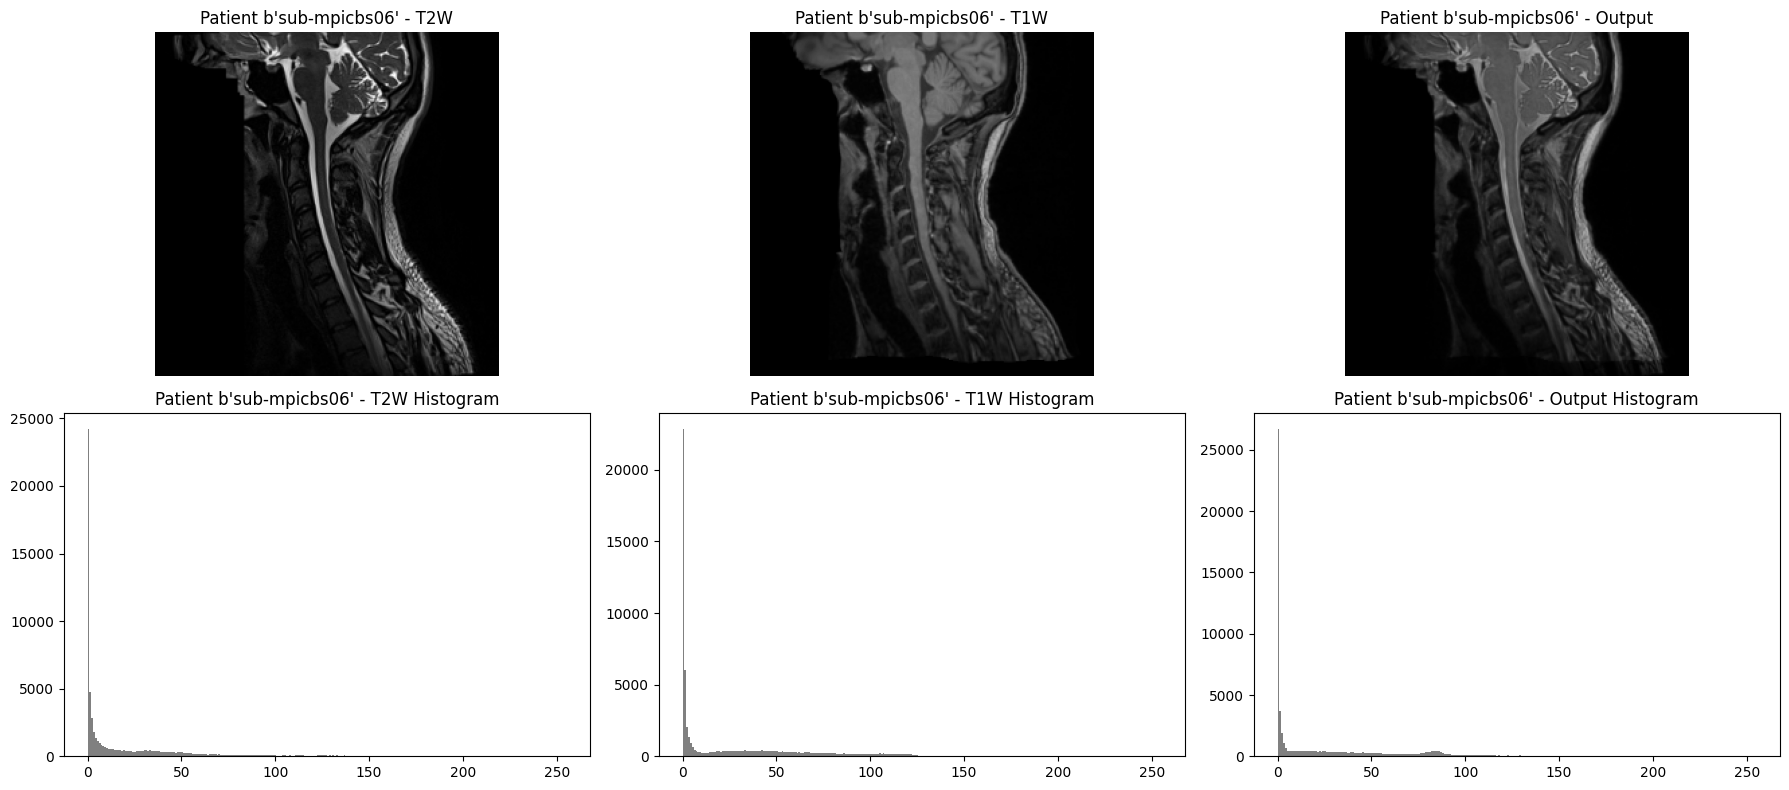

Epoch 6/100, Train Loss: 0.1575, Validation Loss: 0.1577
Epoch 7/100, Train Loss: 0.1574, Validation Loss: 0.1573
Epoch 8/100, Train Loss: 0.1573, Validation Loss: 0.1578
Epoch 9/100, Train Loss: 0.1573, Validation Loss: 0.1571
Epoch 10/100, Train Loss: 0.1573, Validation Loss: 0.1572


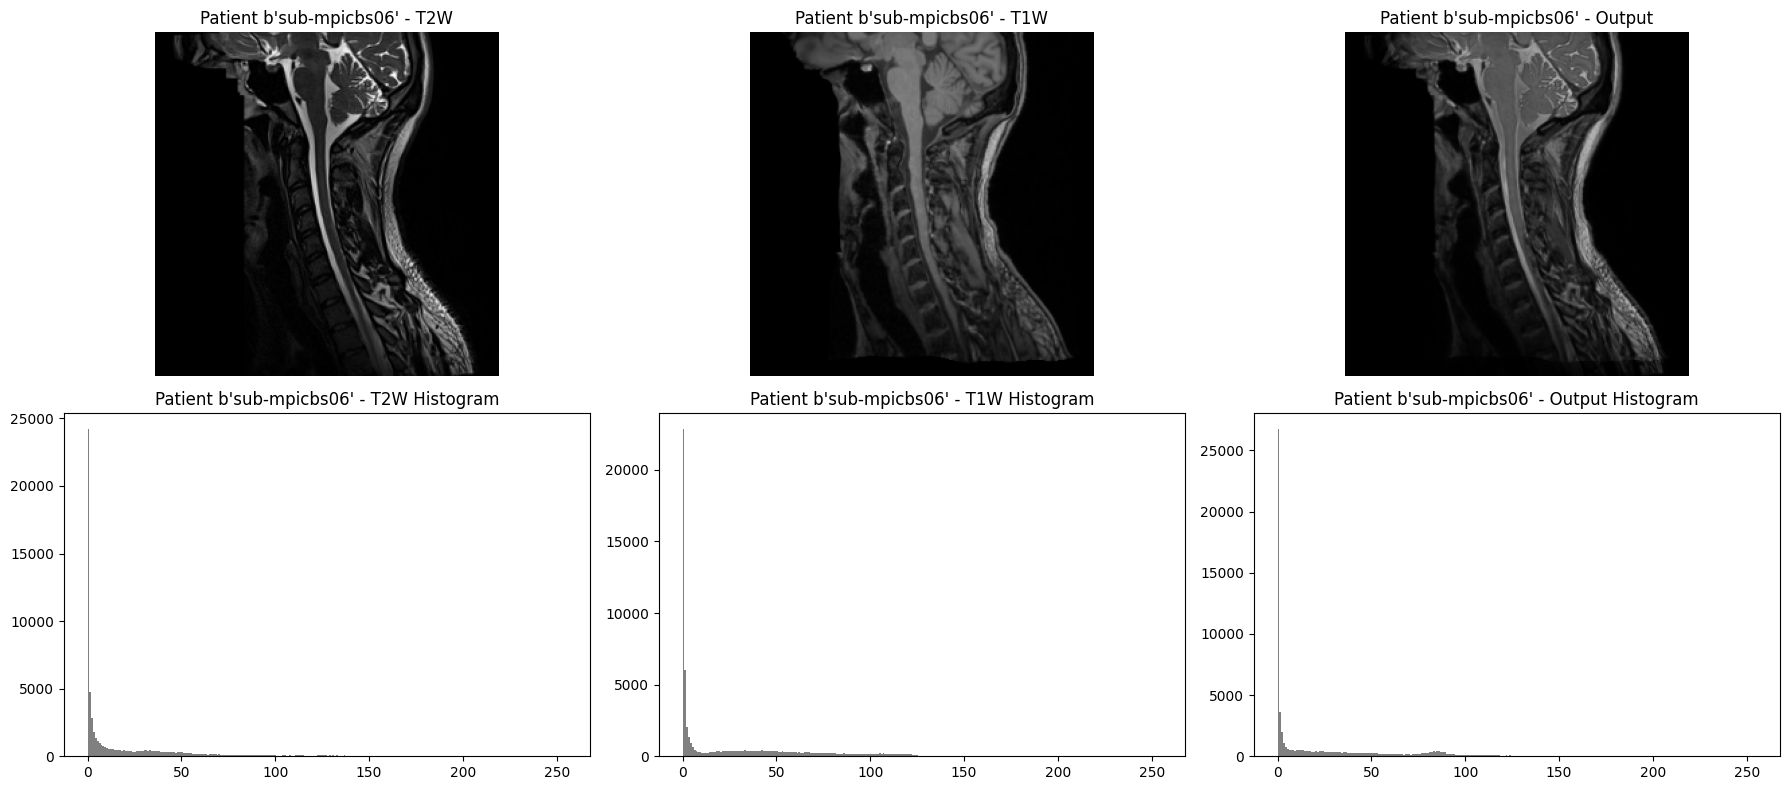

Epoch 11/100, Train Loss: 0.1572, Validation Loss: 0.1573
Epoch 12/100, Train Loss: 0.1572, Validation Loss: 0.1574
Epoch 13/100, Train Loss: 0.1572, Validation Loss: 0.1575
Epoch 14/100, Train Loss: 0.1571, Validation Loss: 0.1575
Early stopping...
Training finished in 744.43 seconds
Validation SSIM: 0.7065, Validation FMI: 0.8556
Training on GPU, with alpha=3, beta=1, gamma=1
Epoch 1/100, Train Loss: 0.1905, Validation Loss: 0.1657
Epoch 2/100, Train Loss: 0.1636, Validation Loss: 0.1649
Epoch 3/100, Train Loss: 0.1632, Validation Loss: 0.1636
Epoch 4/100, Train Loss: 0.1630, Validation Loss: 0.1635
Epoch 5/100, Train Loss: 0.1629, Validation Loss: 0.1634


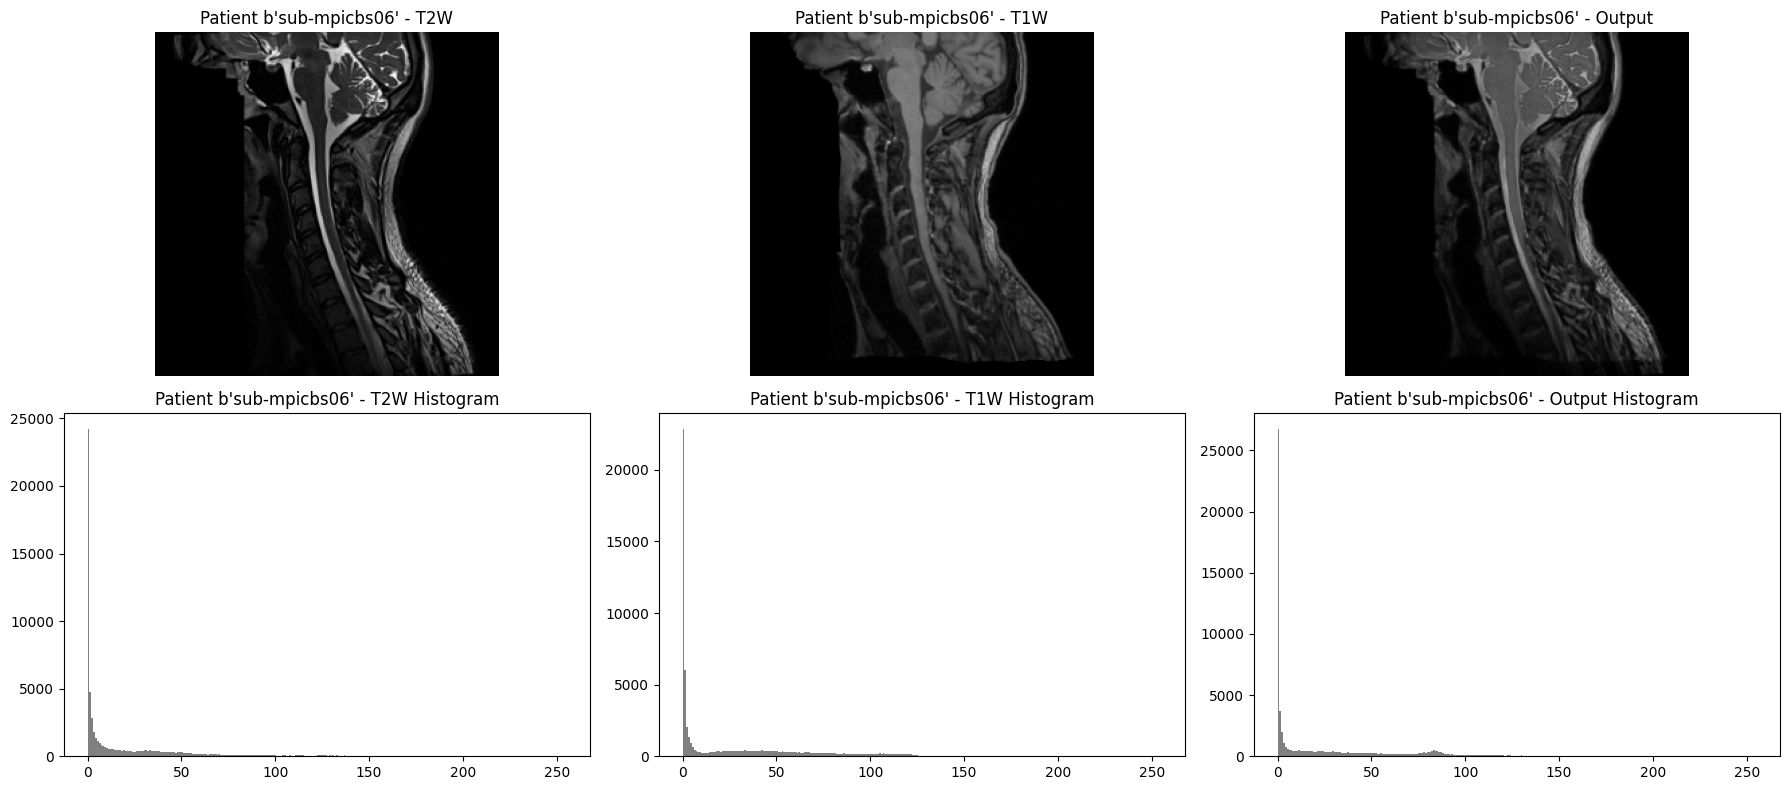

Epoch 6/100, Train Loss: 0.1628, Validation Loss: 0.1635
Epoch 7/100, Train Loss: 0.1628, Validation Loss: 0.1634
Epoch 8/100, Train Loss: 0.1627, Validation Loss: 0.1633
Epoch 9/100, Train Loss: 0.1627, Validation Loss: 0.1632
Epoch 10/100, Train Loss: 0.1627, Validation Loss: 0.1632


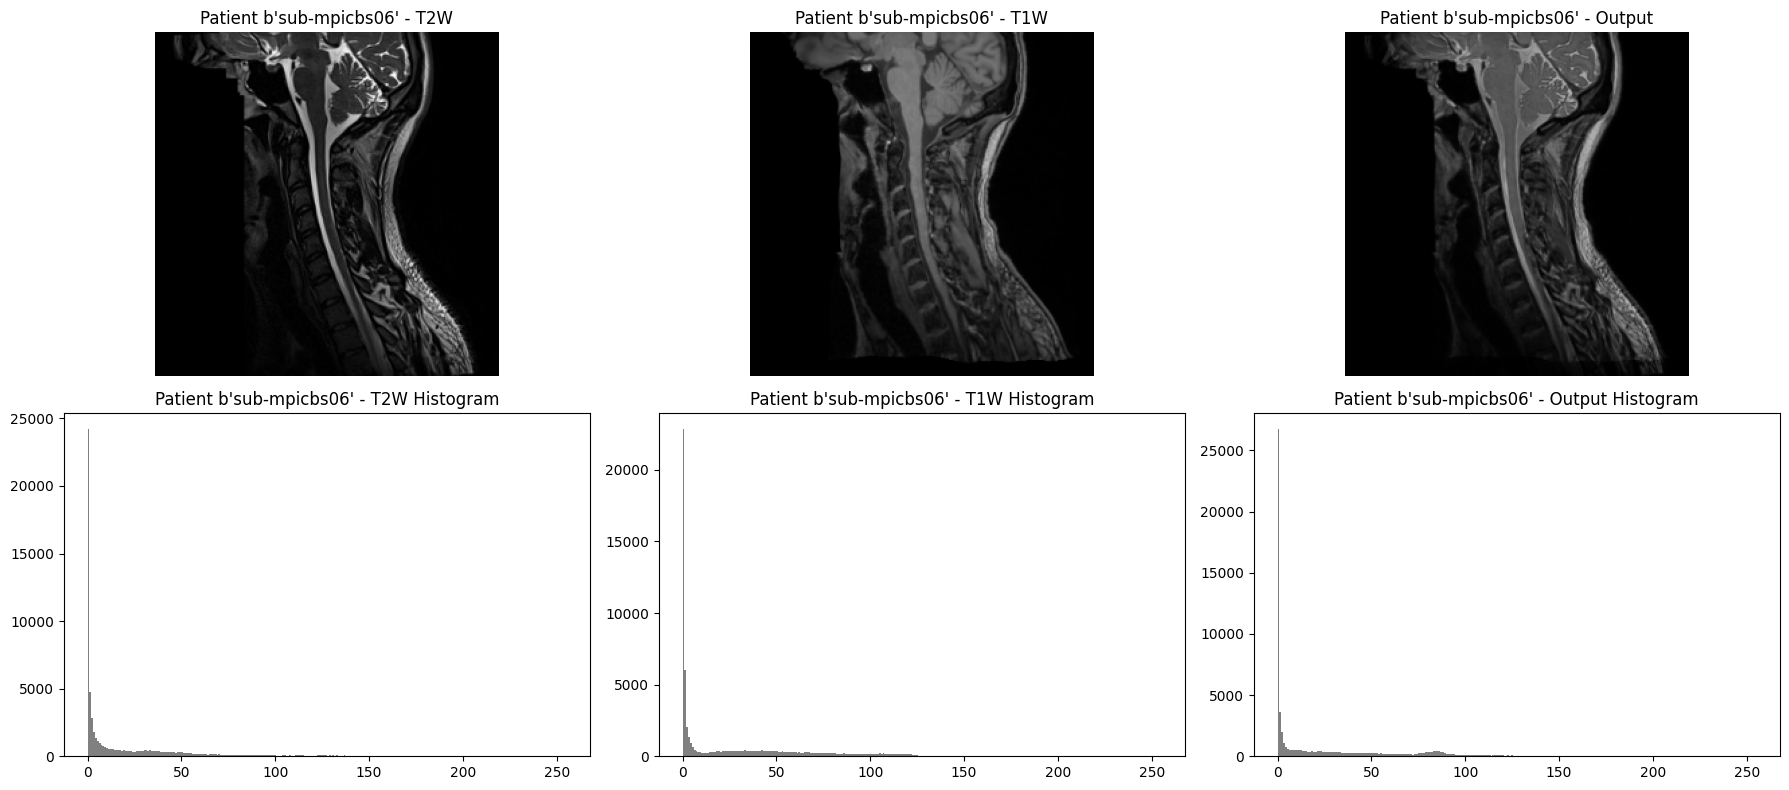

Epoch 11/100, Train Loss: 0.1627, Validation Loss: 0.1632
Epoch 12/100, Train Loss: 0.1627, Validation Loss: 0.1631
Epoch 13/100, Train Loss: 0.1626, Validation Loss: 0.1629
Epoch 14/100, Train Loss: 0.1626, Validation Loss: 0.1628
Epoch 15/100, Train Loss: 0.1627, Validation Loss: 0.1634


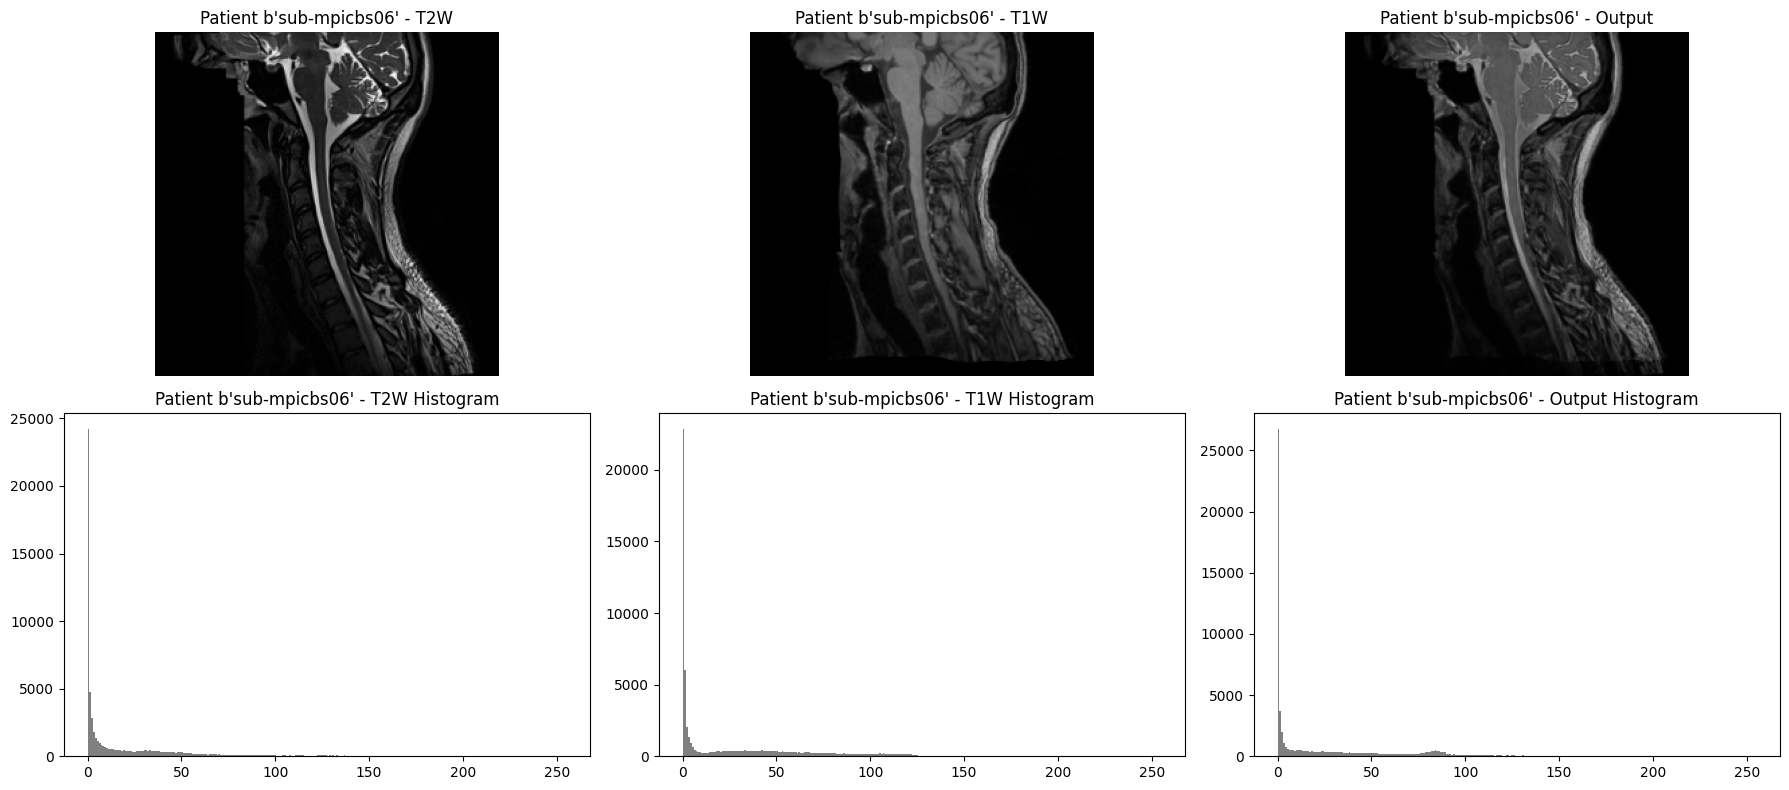

Epoch 16/100, Train Loss: 0.1626, Validation Loss: 0.1630
Epoch 17/100, Train Loss: 0.1626, Validation Loss: 0.1632
Epoch 18/100, Train Loss: 0.1626, Validation Loss: 0.1630
Epoch 19/100, Train Loss: 0.1626, Validation Loss: 0.1631
Early stopping...
Training finished in 1030.77 seconds
Validation SSIM: 0.7299, Validation FMI: 0.8555
Training on GPU, with alpha=4, beta=1, gamma=1
Epoch 1/100, Train Loss: 0.1870, Validation Loss: 0.1700
Epoch 2/100, Train Loss: 0.1689, Validation Loss: 0.1687
Epoch 3/100, Train Loss: 0.1687, Validation Loss: 0.1697
Epoch 4/100, Train Loss: 0.1685, Validation Loss: 0.1720
Epoch 5/100, Train Loss: 0.1685, Validation Loss: 0.1739


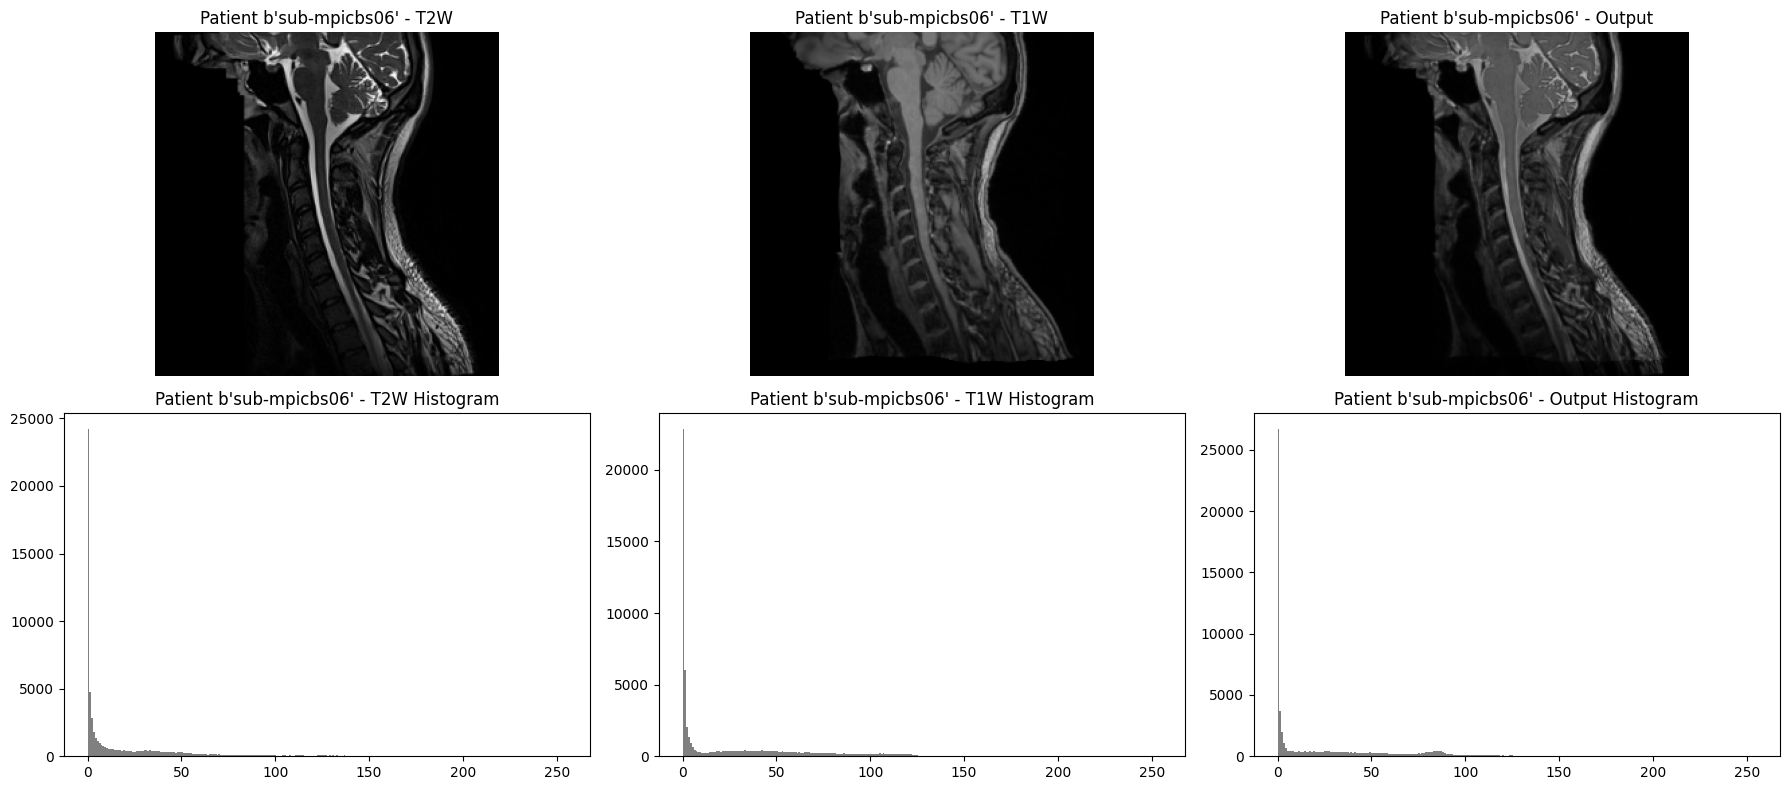

Epoch 6/100, Train Loss: 0.1685, Validation Loss: 0.1724
Epoch 7/100, Train Loss: 0.1686, Validation Loss: 0.1706
Early stopping...
Training finished in 378.09 seconds
Validation SSIM: 0.7354, Validation FMI: 0.8555
Training on GPU, with alpha=1, beta=2, gamma=1
Epoch 1/100, Train Loss: 0.3881, Validation Loss: 0.3880
Epoch 2/100, Train Loss: 0.3888, Validation Loss: 0.3880
Epoch 3/100, Train Loss: 0.3888, Validation Loss: 0.3880
Epoch 4/100, Train Loss: 0.3888, Validation Loss: 0.3880
Epoch 5/100, Train Loss: 0.3888, Validation Loss: 0.3880


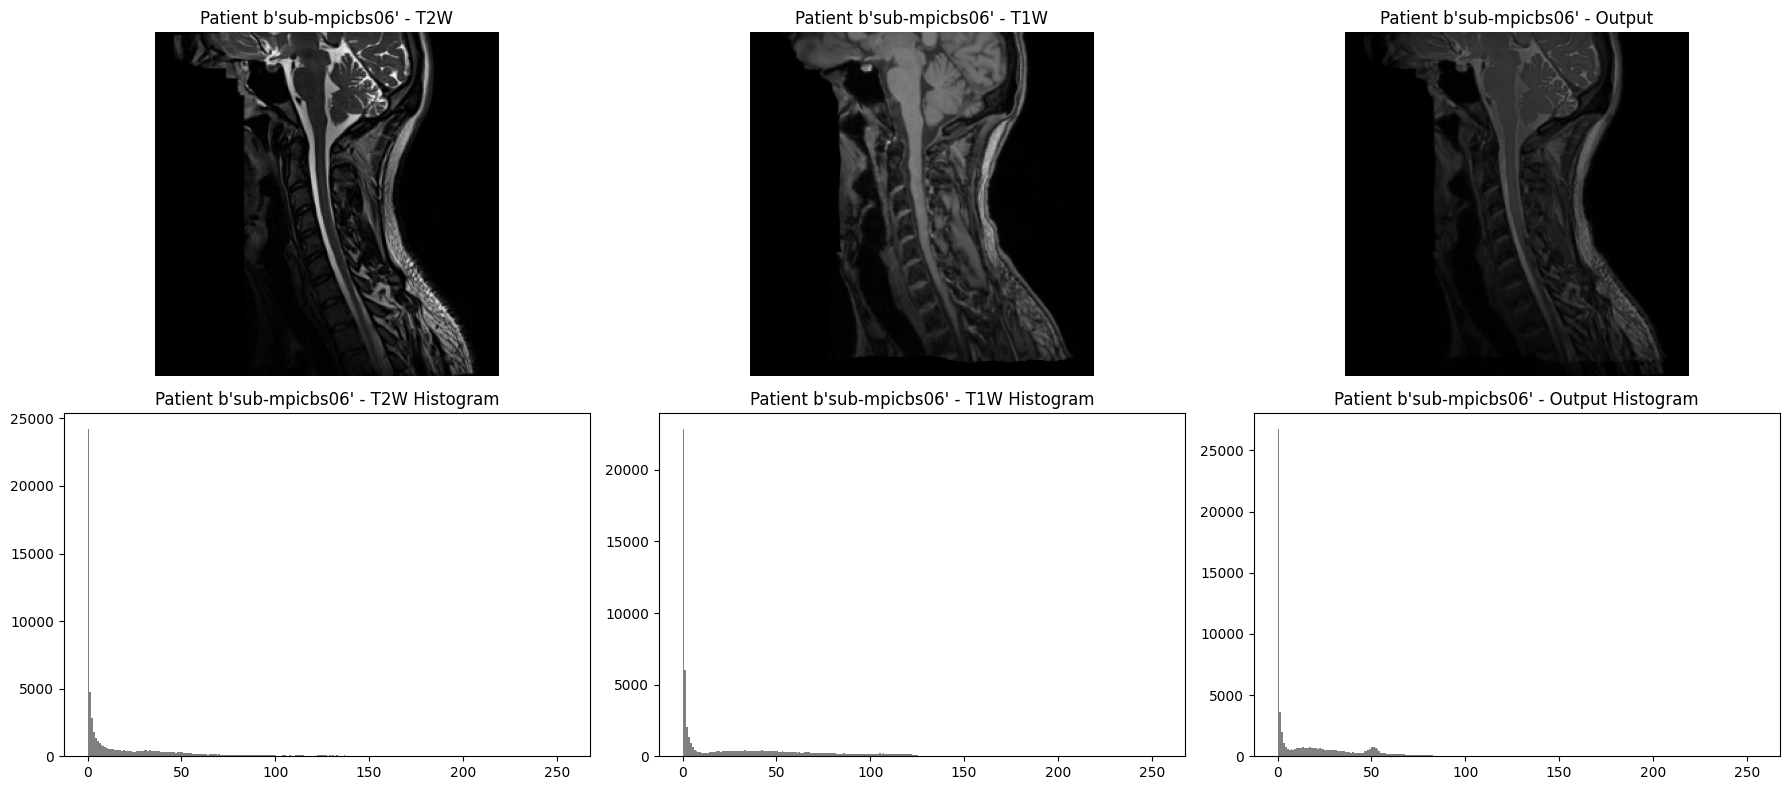

Epoch 6/100, Train Loss: 0.3888, Validation Loss: 0.3880
Epoch 7/100, Train Loss: 0.3888, Validation Loss: 0.3880
Epoch 8/100, Train Loss: 0.3888, Validation Loss: 0.3880
Epoch 9/100, Train Loss: 0.3888, Validation Loss: 0.3880
Epoch 10/100, Train Loss: 0.3888, Validation Loss: 0.3880


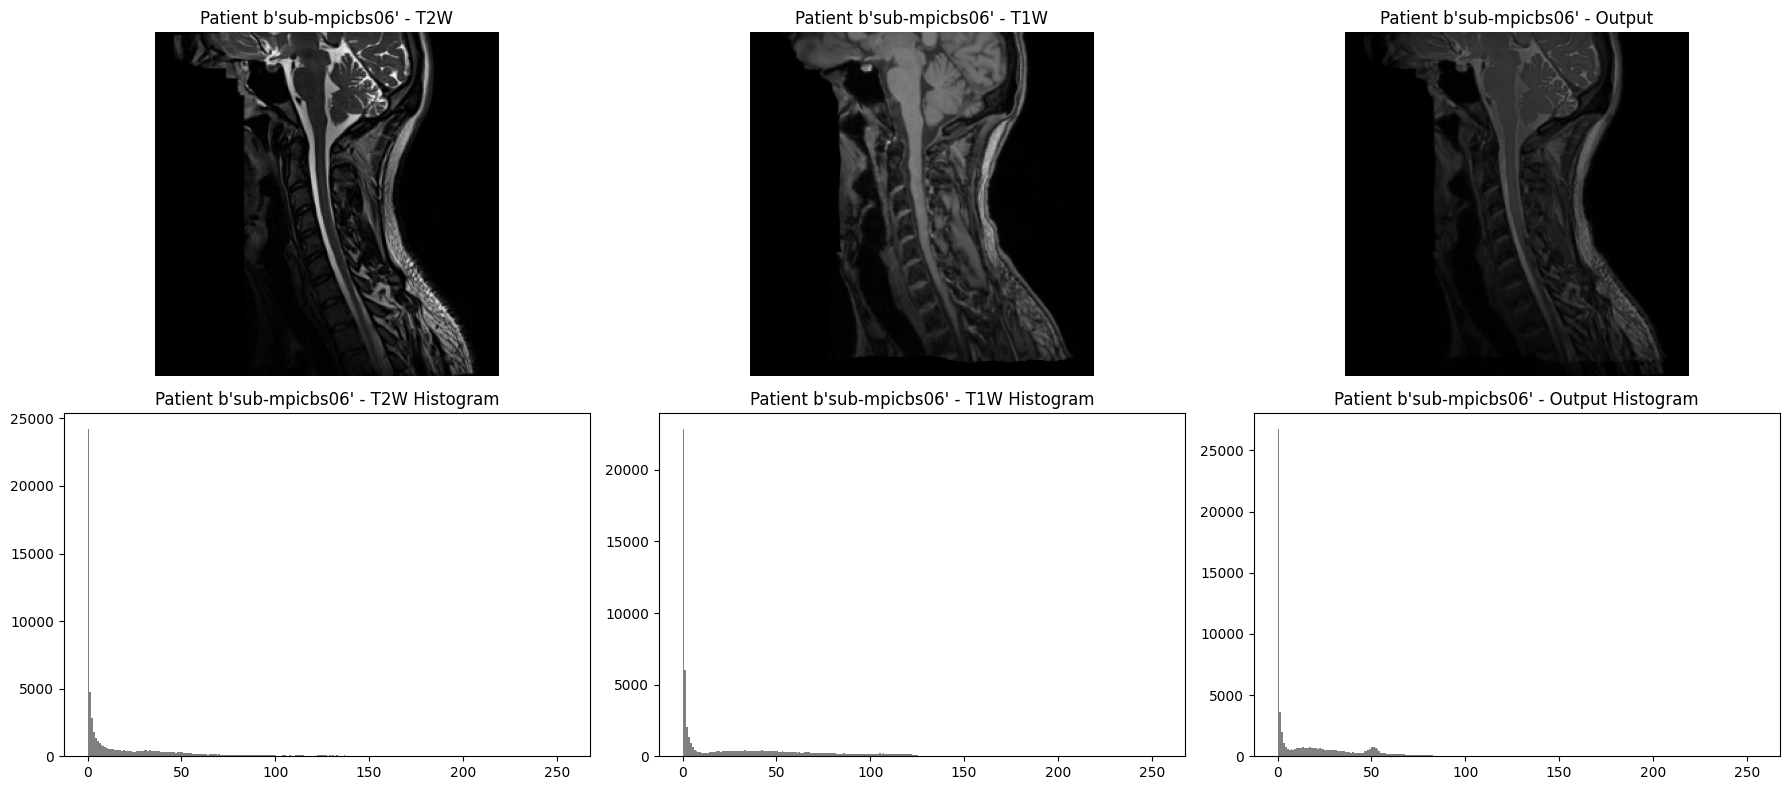

Epoch 11/100, Train Loss: 0.3888, Validation Loss: 0.3880
Epoch 12/100, Train Loss: 0.3888, Validation Loss: 0.3880
Epoch 13/100, Train Loss: 0.3888, Validation Loss: 0.3880
Epoch 14/100, Train Loss: 0.3888, Validation Loss: 0.3880
Epoch 15/100, Train Loss: 0.3888, Validation Loss: 0.3880
Early stopping...
Training finished in 807.84 seconds
Validation SSIM: 0.7230, Validation FMI: 0.8556
Training on GPU, with alpha=1, beta=3, gamma=1
Epoch 1/100, Train Loss: 0.4536, Validation Loss: 0.4534
Epoch 2/100, Train Loss: 0.4545, Validation Loss: 0.4534
Epoch 3/100, Train Loss: 0.4545, Validation Loss: 0.4534
Epoch 4/100, Train Loss: 0.4545, Validation Loss: 0.4534
Epoch 5/100, Train Loss: 0.4545, Validation Loss: 0.4534


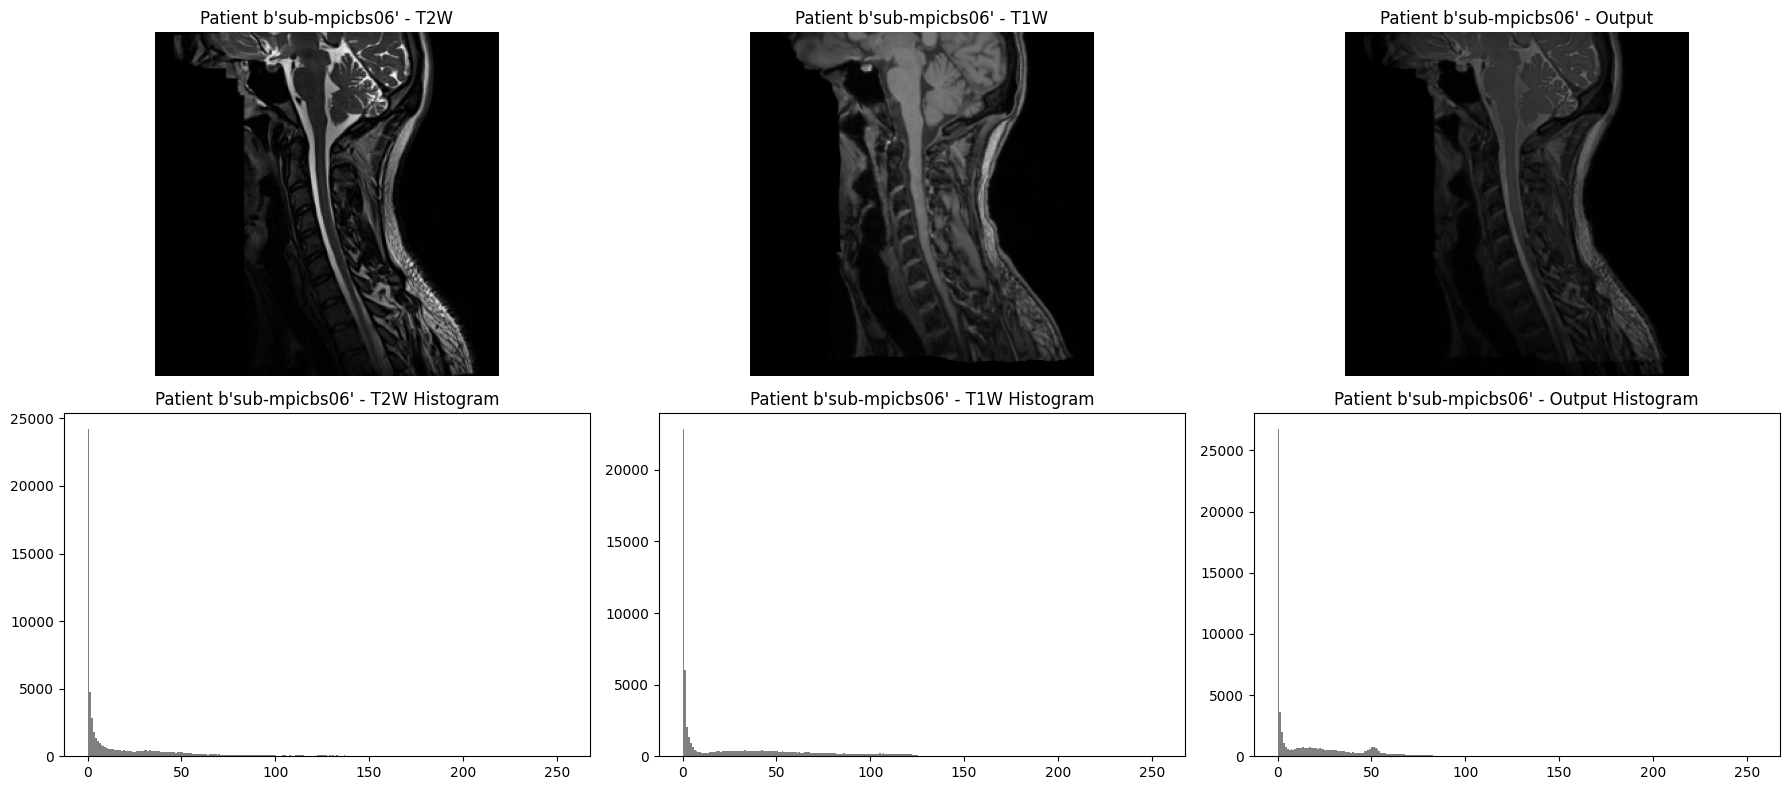

Epoch 6/100, Train Loss: 0.4545, Validation Loss: 0.4534
Early stopping...
Training finished in 326.35 seconds
Validation SSIM: 0.7145, Validation FMI: 0.8556
Training on GPU, with alpha=1, beta=4, gamma=1
Epoch 1/100, Train Loss: 0.5132, Validation Loss: 0.5117
Epoch 2/100, Train Loss: 0.5130, Validation Loss: 0.5117
Epoch 3/100, Train Loss: 0.5130, Validation Loss: 0.5117
Epoch 4/100, Train Loss: 0.5130, Validation Loss: 0.5117
Epoch 5/100, Train Loss: 0.5130, Validation Loss: 0.5117


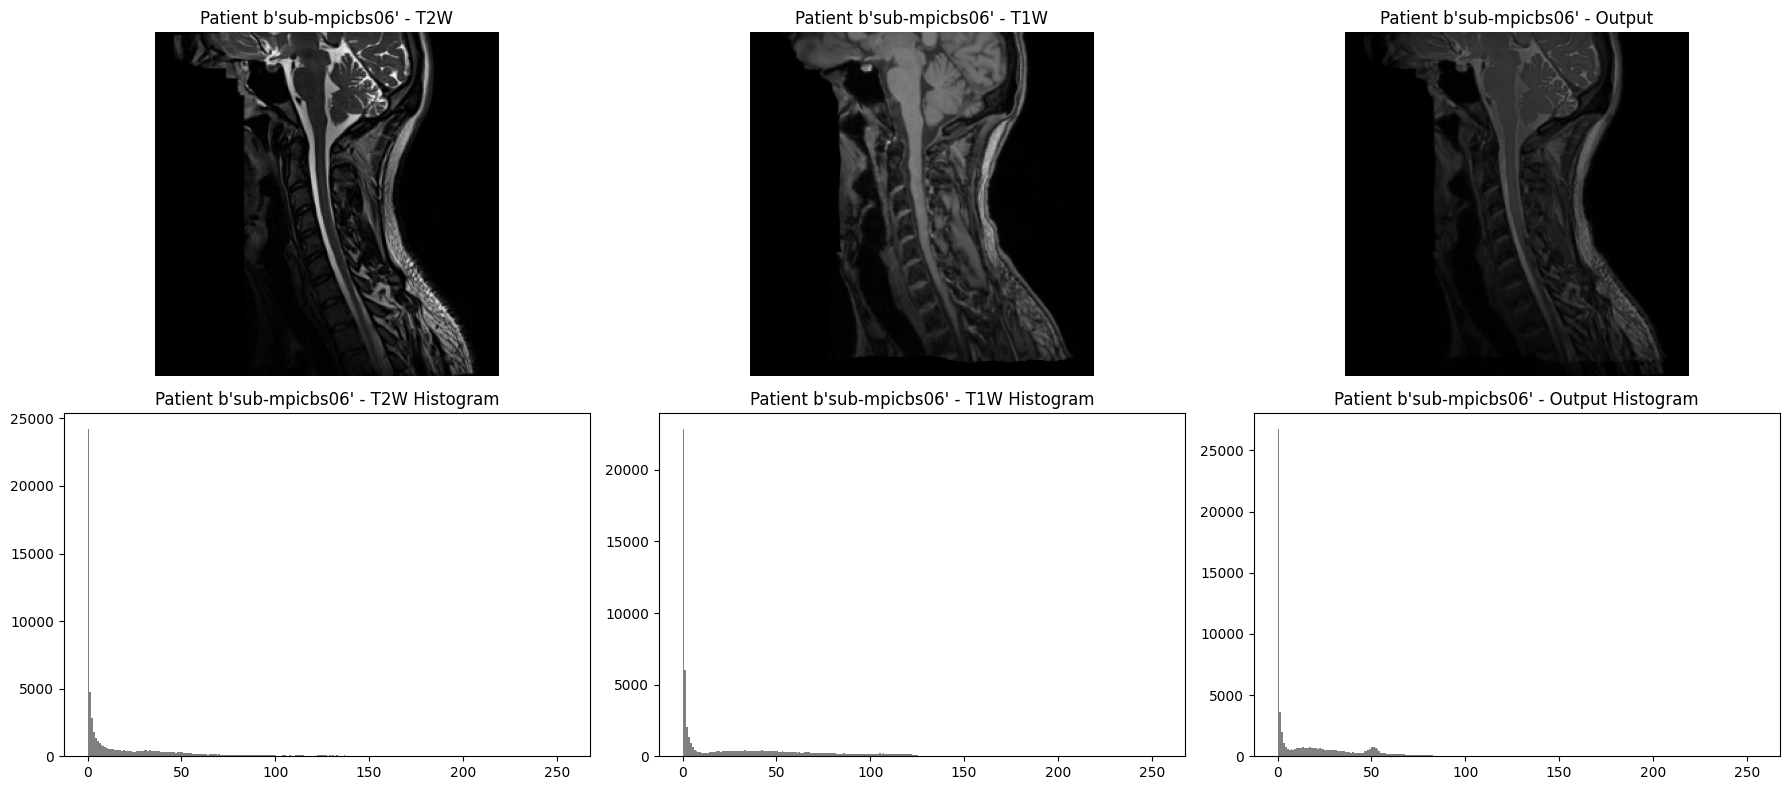

Epoch 6/100, Train Loss: 0.5130, Validation Loss: 0.5117
Epoch 7/100, Train Loss: 0.5130, Validation Loss: 0.5117
Early stopping...
Training finished in 378.54 seconds
Validation SSIM: 0.7041, Validation FMI: 0.8557
Best model parameters: {'alpha': 1, 'beta': 1, 'gamma': 1}


In [5]:
# Initialize Weights and Biases
wandb.init(project='multicontrast-fusion', entity='biancapopa')

model_template = build_model([(256, 256, 1), (256, 256, 1)])  # for 2 input branches

# Define parameters to iterate over
combinations = [
    (1, 1, 1),
    (1, 1, 2),
    (1, 1, 3),
    (1, 1, 4),
    (2, 1, 1),
    (3, 1, 1),
    (4, 1, 1),
    (1, 2, 1),
    (1, 3, 1),
    (1, 4, 1)
]

# Training configuration
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
max_epochs = 100
patience = 5
display_step = 5  # Display images every N epochs

best_model_score = float('-inf')
best_model_params = {}

fmi_scores = []
ssim_scores = []

for alpha, beta, gamma in combinations:
            with tf.device('/GPU:0' if gpus else '/CPU:0'):
                print(f"Training on {'GPU' if gpus else 'CPU'}, with alpha={alpha}, beta={beta}, gamma={gamma}")

                # Re-initialize model for each parameter combination
                model = tf.keras.models.clone_model(model_template)
                model.compile(optimizer=optimizer, loss=get_custom_loss(alpha, beta, gamma))

                # Initialize early stopping parameters
                best_val_loss = float('inf')
                wait = 0
                start_time = time.time()    

                for epoch in range(max_epochs):
                    train_loss = 0
                    val_loss = 0
                    num_batches_train = 0
                    num_batches_val = 0

                    # Training loop
                    for images in train_dataset:
                        image1, image2 = images['t2w'], images['t1w']
                        with tf.GradientTape() as tape:
                            predictions = model([image1, image2], training=True)
                            loss = custom_multi_ssim_loss([image1, image2], predictions, alpha=alpha, beta=beta, gamma=gamma)
                        grads = tape.gradient(loss, model.trainable_weights)
                        optimizer.apply_gradients(zip(grads, model.trainable_weights))
                        train_loss += loss.numpy()
                        num_batches_train += 1

                    train_loss /= num_batches_train

                    # Validation loop
                    for images in val_dataset:
                        image1, image2 = images['t2w'], images['t1w']
                        predictions = model([image1, image2], training=False)
                        loss = custom_multi_ssim_loss([image1, image2], predictions, alpha=alpha, beta=beta, gamma=gamma)
                        val_loss += loss.numpy()
                        num_batches_val += 1

                    val_loss /= num_batches_val

                    print(f"Epoch {epoch+1}/{max_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

                    # Early stopping check
                    if val_loss < best_val_loss:
                        best_val_loss = val_loss
                        wait = 0
                    else:
                        wait += 1
                        if wait >= patience:
                            print("Early stopping...")
                            break

                    # Display images and statistics
                    if (epoch + 1) % display_step == 0:
                        images = next(iter(val_dataset))
                        image1, image2, patient_id = images['t2w'], images['t1w'], images['patient_id']
                        val_output = model([image1, image2], training=False)
                        display_images_and_histograms(image1[0], image2[0], val_output[0], patient_id[0])
                        fmi_scores.append(fmi_score(image1, image2, val_output))
                        ssim_scores.append(ssim_score([image1, image2], val_output, alpha=alpha, beta=beta, gamma=gamma))

                print(f"Training finished in {time.time() - start_time:.2f} seconds")

                # Evaluate model performance
                ssim_val = np.mean(ssim_scores)
                fmi_val = np.mean(fmi_scores)

                # Print performance
                print(f"Validation SSIM: {ssim_val:.4f}, Validation FMI: {fmi_val:.4f}")

                # Log performance
                wandb.log({'alpha': alpha, 'beta': beta, 'gamma': gamma, 'val_loss': best_val_loss, 'SSIM': ssim_val, 'FMI': fmi_val})

                # Save best model
                current_score = ssim_val + fmi_val # Scoring function
                if current_score > best_model_score:
                    best_model_score = current_score
                    best_model_params = {'alpha': alpha, 'beta': beta, 'gamma': gamma}
                    model.save(f"best_model_alpha{alpha}_beta{beta}_gamma{gamma}.h5")
                    print(f"New best model saved with alpha={alpha}, beta={beta}, gamma={gamma}")

print(f"Best model parameters: {best_model_params}")

In [6]:
test_fmi_scores = []
test_ssim_scores = []
alpha = best_model_params['alpha']
beta = best_model_params['beta']
gamma = best_model_params['gamma']

# Recreate the custom loss function with the same parameters used during training
custom_loss = get_custom_loss(alpha=alpha, beta=beta, gamma=gamma)

model = tf.keras.models.load_model(f"best_model_alpha{alpha}_beta{beta}_gamma{gamma}.h5", custom_objects={'custom_loss': custom_loss})

# No need to track gradients here
with tf.device('/GPU:0'):
    for images in test_dataset:
    #  images = next(iter(test_dataset))
        image1, image2 = images['t2w'], images['t1w']  
        test_output = model([image1, image2], training=False)  # Generate predictions
        fmi_score_result = fmi_score(image1, image2, test_output)  # Calculate FMI score between ground truth and prediction
        ssim_score_result = ssim_score([image1, image2], test_output, alpha=alpha, beta=beta, gamma=gamma)
        test_fmi_scores.append(fmi_score_result)
        test_ssim_scores.append(ssim_score_result)

average_test_fmi = np.mean(test_fmi_scores)
average_test_ssim = np.mean(test_ssim_scores)

print("Average FMI on test set:", average_test_fmi)
print("Average SSIM on test set:", average_test_ssim)


Average FMI on test set: 0.8557099441747072
Average SSIM on test set: 0.8465103
